# Train ADAGE models

### Georgia Doing 2020

This notebook walks through first training an ADAGE model on the same array compnedium that published eADAGE was trained on and then training a seqADAGE model on a compendium of *P. aeruginosa* RNAseq data. The focus is on the validating the work-flow switch from TensorFlow code by Jie from 2016 to updated code usig the Keras library (tensorflow backend).

The main objectives are to validate the training workflow using
1. Loss and validation loss curves
2. Node weight distributions
3. Node KEGG and GO enrichments

In [2]:
import run_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imp import reload
import Adage
from scipy.stats import hypergeom
import csv

Using TensorFlow backend.


In [3]:
# for dev purposes, while updating run_model.py need to reload
# for dev purposes, while updating run_model.py need to reload
reload(run_model)
reload(Adage)

<module 'Adage' from '/home/georgia/Dropbox (Hogan Lab)/Digital_notebook/2020_06_02_eADAGE_adapt/seqADAGE/Adage.py'>

## Array-based ADAGE (compared to published ADAGE)

For the sake of this comparison, both models share the following parameters:

* hidden features: 300
* epochs: 500
* curruption: 0.01
* batchs zie: 10
* validatoin split: 0.1
* activation: sigmoid
* objective: binary cross-entropy

Note: the TensorFlow ADAGE was trained using Jie's code from Github a while ago, not within this notebook.

First things, let's take a look at our input data/training compnedium. This is the compendium of array data assembled by Jie (for TensorFlow ADAGE) in 2014 (?) and normalized using Ji'es original workflow.

In [4]:
#adage_comp = pandas.read_csv('data_files/ADAGE_compendium.csv')
all_comp = np.loadtxt(open('data_files/ADAGE_compendium.csv', "rb"),delimiter=',',skiprows = 1)
gene_num = np.size(all_comp, 0)
samp_num = np.size(all_comp, 1)
print(gene_num, samp_num)

5210 1051


This training compendium has 'gene_sum' genes (rows) and 'samp_sum)' samples (columns).

This data has been 0-1 saled and has as lightly skewed distribution,

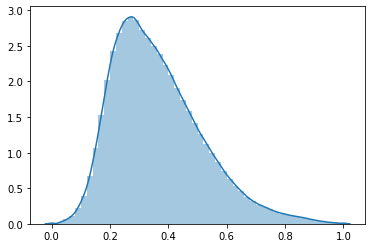

In [5]:
fig = sns.distplot(all_comp)

In [ ]:
fig.figure.savefig('array_dist.png')

And now we load the TensorFlow trained ADAGE model.

First train a keras model on this compendium.

In [ ]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict = {
    "tf_adage": tf_adage
}

for seed in range(10):
    for i in inits:
    #print(i)
        for l in L1_norm:
        #print(l)
            for a in act_fun:
            #print(a)
                for t in tied:
                    m = run_model.run_model('data_files/train_set_normalized.csv',seed=seed+460,kl1=l, act = a, tied = t, epochs=500, init=i)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                    print(name)
                    model_dict[name] = m

In [ ]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict2 = {
    "tf_adage": tf_adage
}
model_dict_seq2 = {
    "tf_adage": tf_adage
}

for seed in range(10):
    for i in inits:
    #print(i)
        for l in L1_norm:
        #print(l)
            for a in act_fun:
            #print(a)
                for t in tied:
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                    print(name)
                    mseq = run_model.run_model('data_files/refine_bio_seq_clean_with_names.csv',seed=seed+560,kl1=l, act = a, tied = t, epochs=500, init=i)
                    marr = run_model.run_model('data_files/train_set_normalized.csv',seed=seed+560,kl1=l, act = a, tied = t, epochs=500, init=i)

                    model_dict2[name] = marr
                    model_dict_seq2[name] = mseq

And now we load the TensorFlow trained ADAGE model and 'cast' it into and Adage object.

In [ ]:
for m in model_dict:
    print(model_dict[m])

### Alt. Load models from files



In [116]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict = {
    "tf_adage": tf_adage
}

for i in inits:
    #print(i)
    for l in L1_norm:
        #print(l)
        for a in act_fun:
            #print(a)
            for t in tied:
                for s in range(3):
                    seed = str(460 + s)
                    #print(t)
                    #m = run_model.run_model('data_files/train_set_normalized.csv',seed=460,kl1=l, act = a, tied = t, epochs=500, init=i)
                    prefix = 'data_files/train_set_normalized_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:500_tied:' + str(t)
                    #print(prefix)
                    weights_temp = np.array(pandas.read_csv('outputs/' + prefix + '_en_weights.csv', header = None))
                    loss_temp = np.array(pandas.read_csv('outputs/' + prefix + '_loss.csv', header = None))
                    val_loss_temp = np.array(pandas.read_csv('outputs/' + prefix + '_val_loss.csv', header = None))
                    adage_temp = Adage.Adage(tf_adage.autoencoder, tf_adage.history, tf_adage.compendium)
                    adage_temp.weights = weights_temp
                    adage_temp.loss = loss_temp[0]
                    adage_temp.val_loss = val_loss_temp[0]
                    adage_temp.set_hwg_cutoff(2.5)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_dict[name] = adage_temp
          
                    
for m in model_dict:
    print(model_dict[m])

### 1. Training Loss

Plotting the loss over epochs as the model is trained.

Note: TF ADAGE logs 'cost' wihle Keras ADAGE outputed 'loss' and 'validation loss' so the two models are definitely logging different statistics evident by the orders of magnitudes of the values (b/c batch sum v mean?).

[Text(0.5, 1, 'tf_adage')]

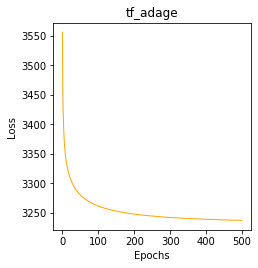

In [87]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)


#name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
name = 'tf_adage'
model_temp = model_dict[name]
ax.plot(list(range(0,500)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
ax.set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
#ax.axvline(x = np.std(model_temp.weights)*2.5)
#ax.axvline(x = np.std(model_temp.weights)*-2.5)
ax.set(title = name)
#ax.set_yscale('log')



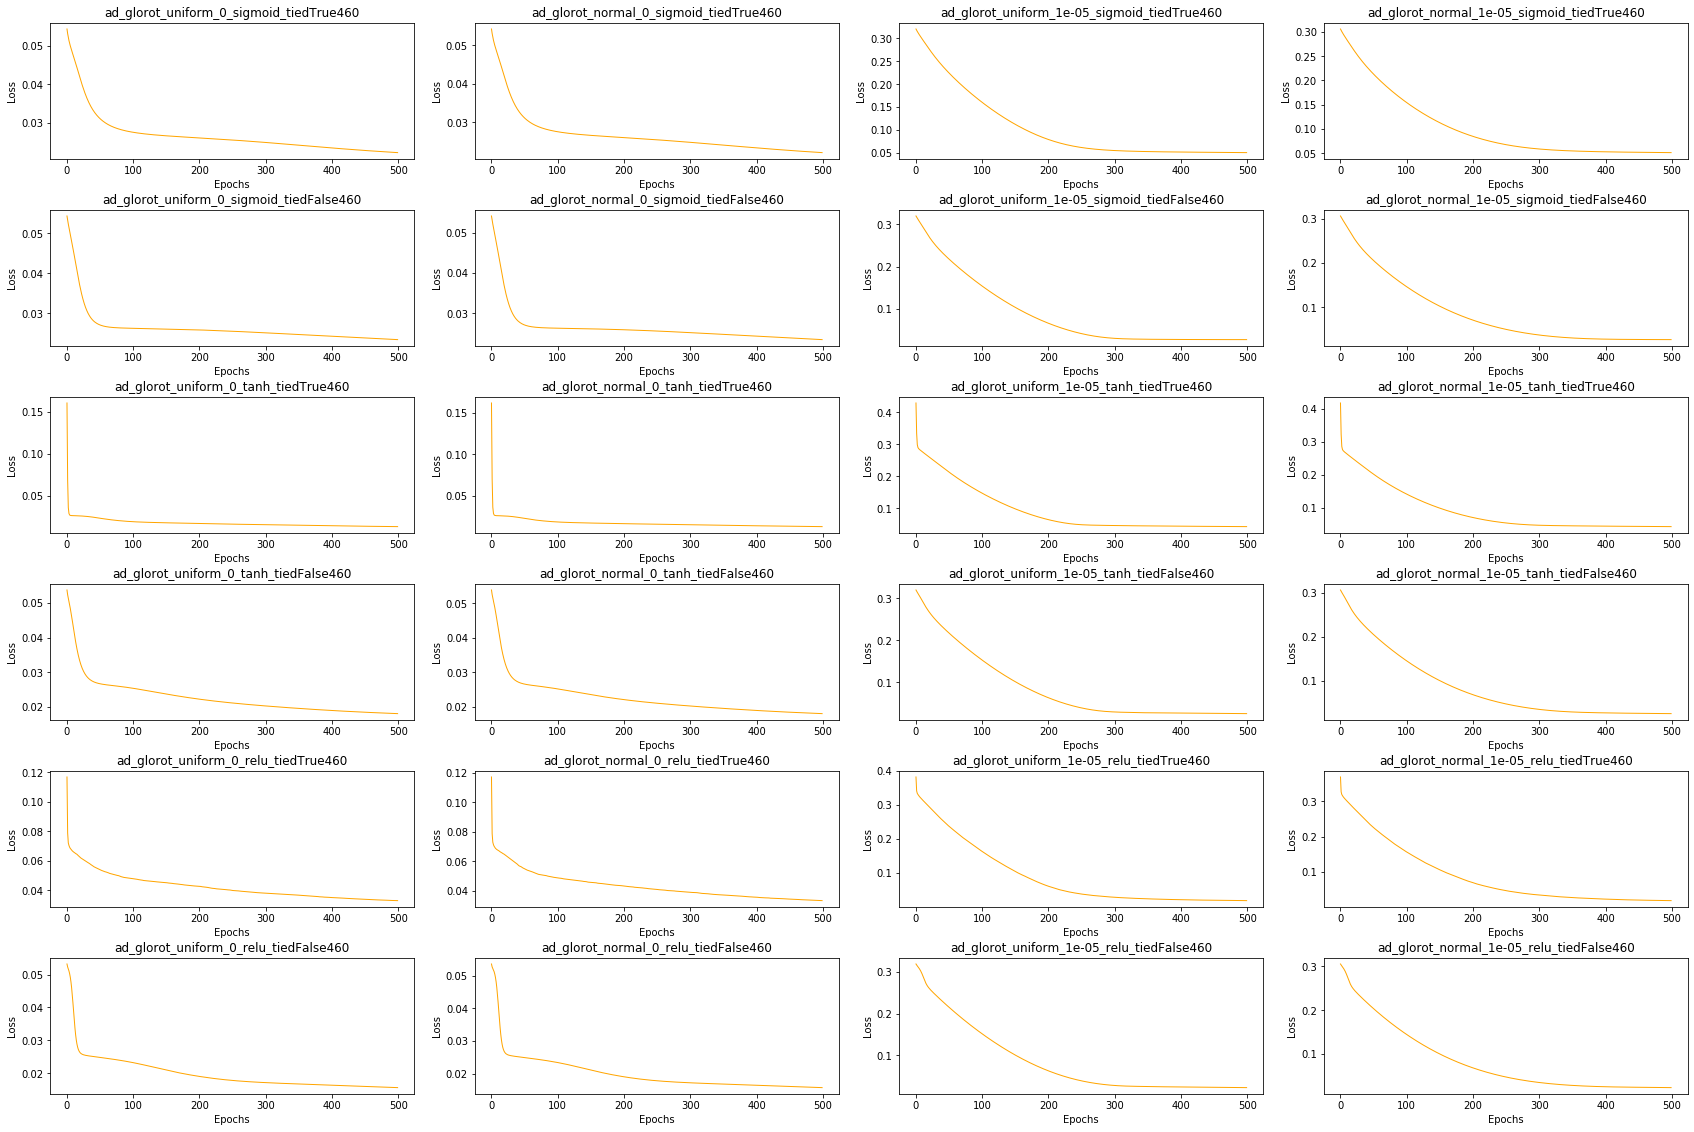

In [33]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].plot(list(range(0,500)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
                ax[xi,yi].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
                xi = xi+1
        yi=yi+1


    

In [ ]:
fig.savefig('loss_array.png')

*Takeaway*: Both models reach asymptotes though TF ADAGE has a sharper elbow, perhaps due to L1?

### 2. Node weight dists

We expect the node weights to follow a *certain* distribution and this has bene important for our definition of 'high weight genes' and our interpretation of ADAGE models. 

[Text(9.125, 0.5, '# Nodes'),
 Text(0.5, 15.0, '# HW genes'),
 Text(0.5, 1, 'tf_adage')]

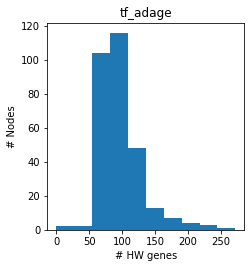

[Text(0.5, 1, 'tf_adage')]

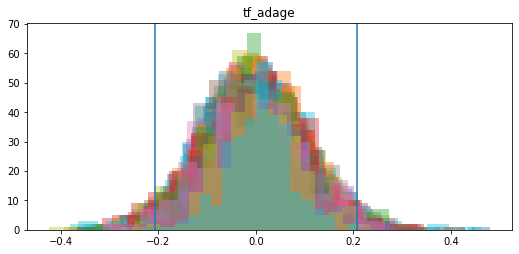

In [232]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*8 ,yd *4))
fig.tight_layout(pad=3.0)


#name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
name = 'tf_adage'
model_temp = model_dict[name]
for node in range(0,300):
    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
    ax=ax,
    hist=True,
    kde=False,
    rug=False)
ax.axvline(x = np.std(model_temp.weights)*2.5)
ax.axvline(x = np.std(model_temp.weights)*-2.5)
ax.set(title = name)
#ax.set_yscale('log')




In [ ]:
fig.savefig('weight_dists_adage.png')

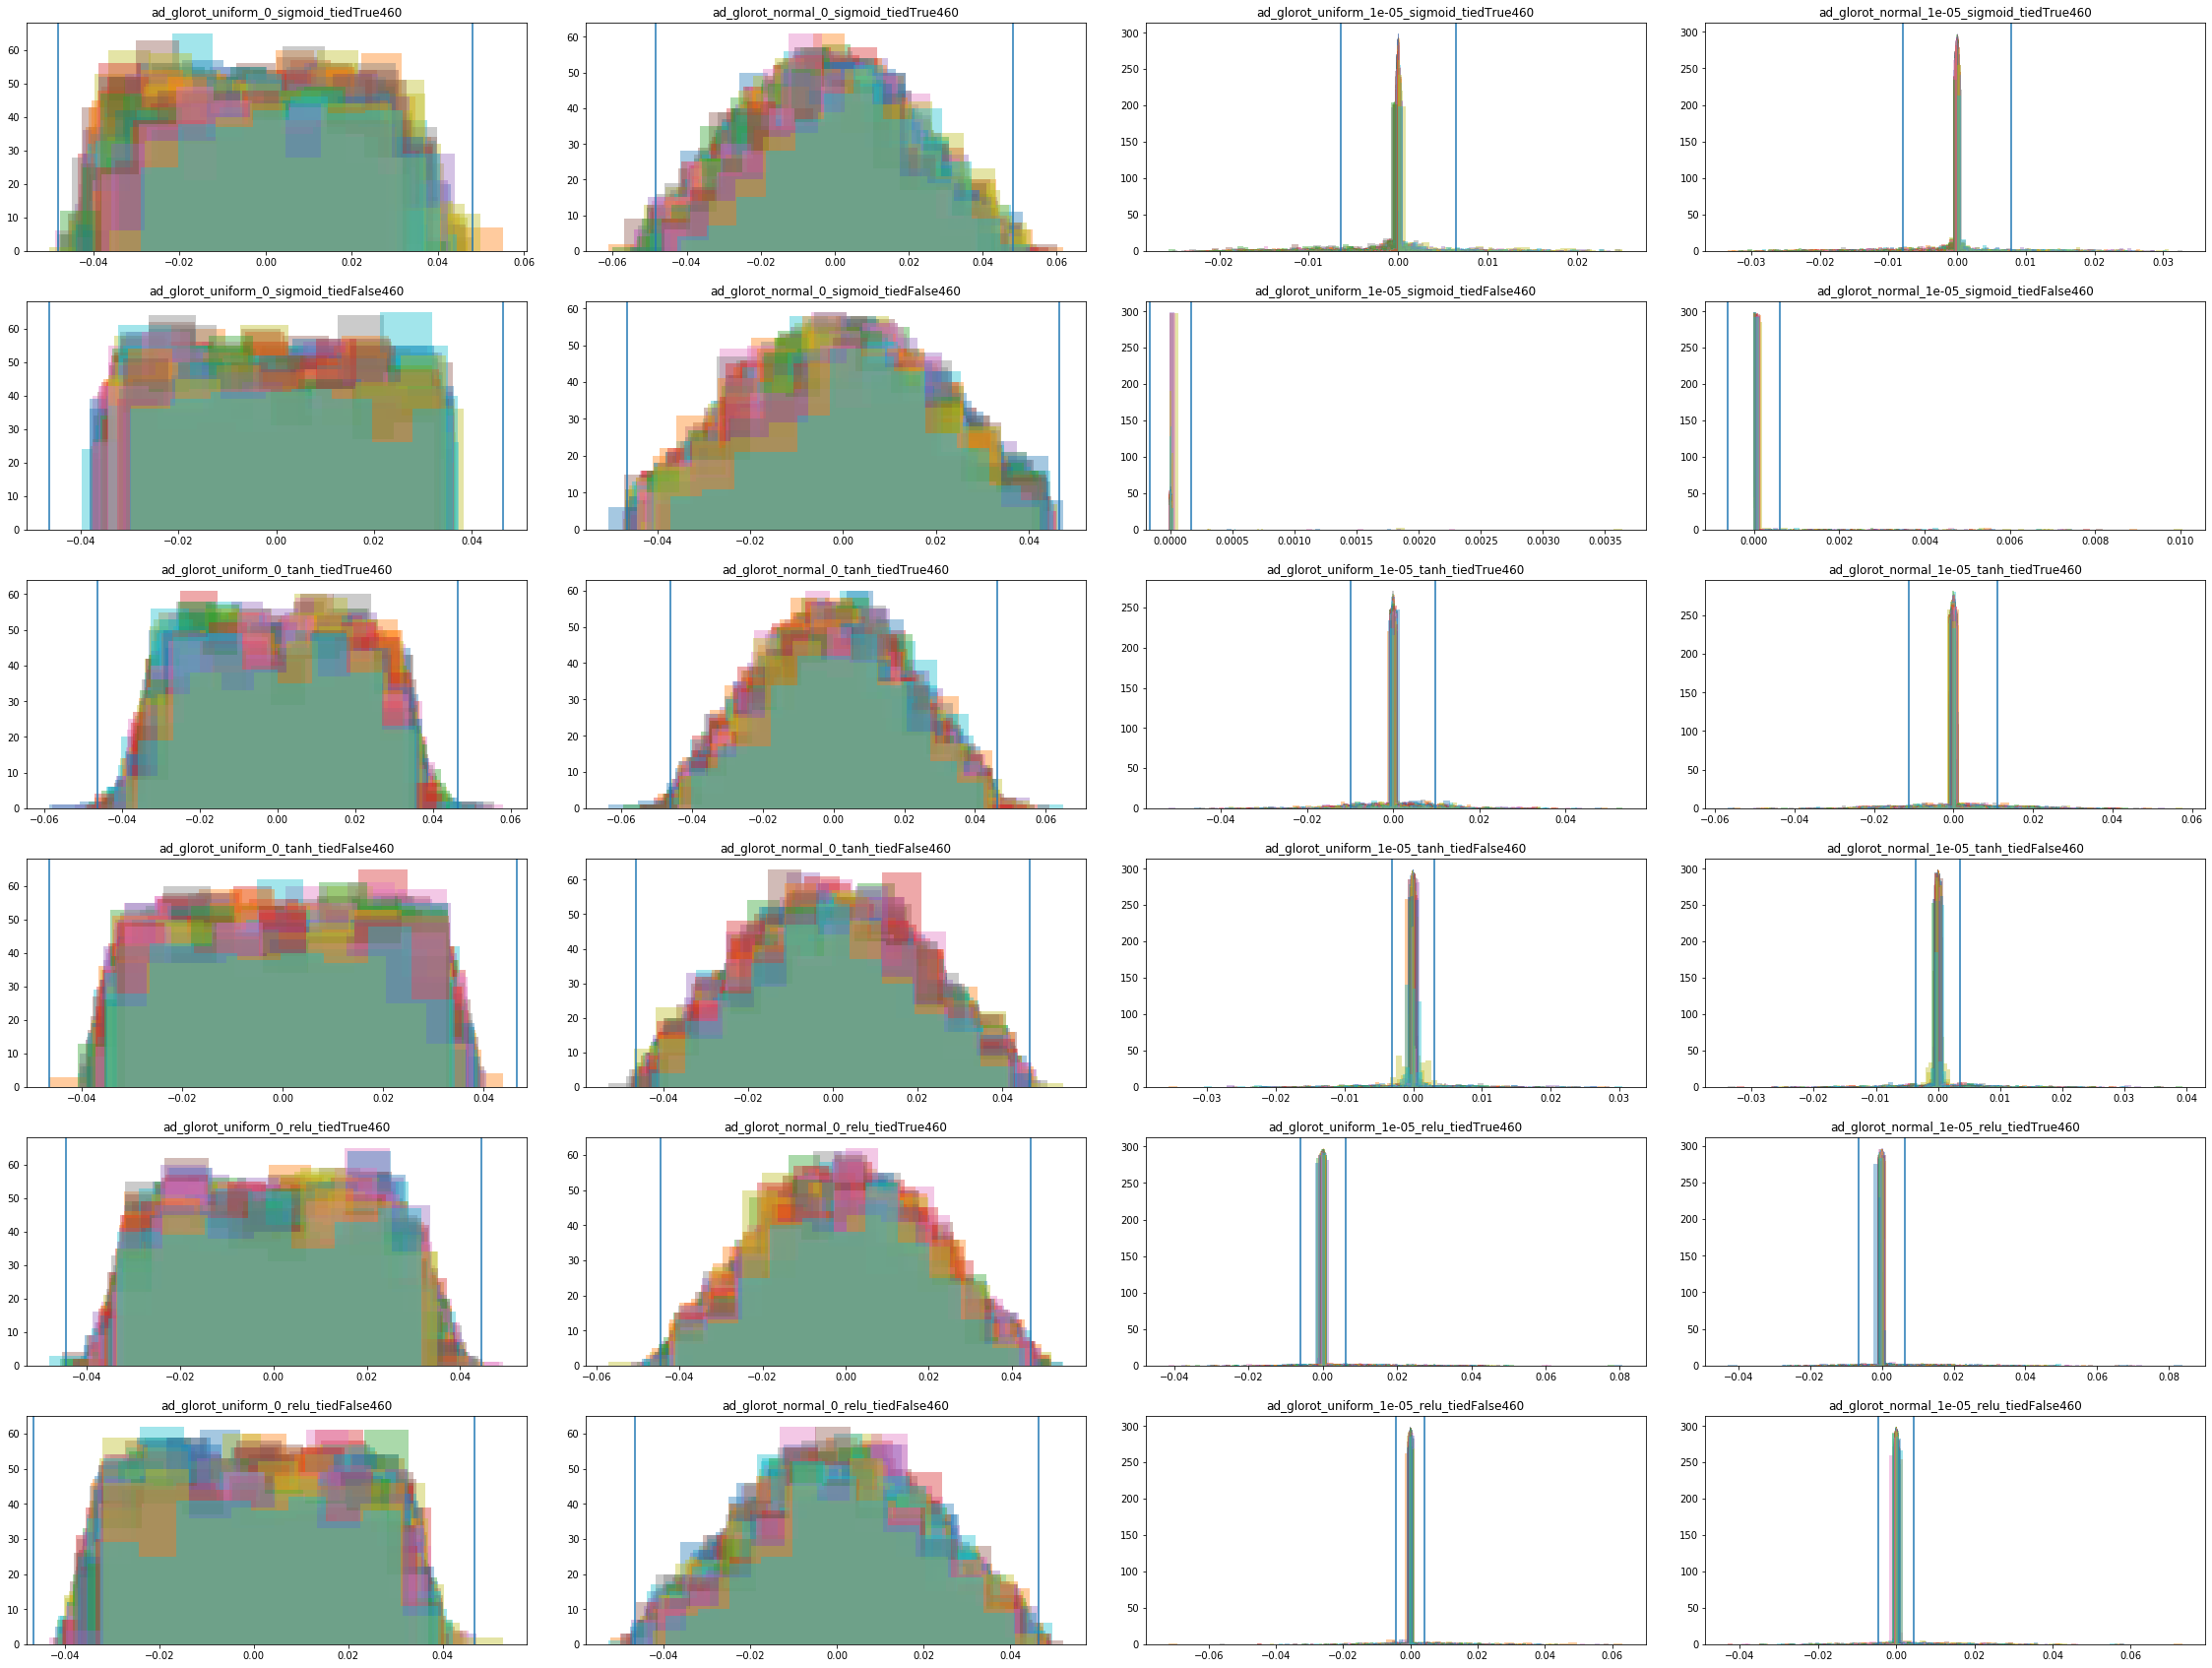

In [233]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(yd*8 ,xd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
                model_temp = model_dict[name]
                for node in range(0,300):
                    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
                        ax=ax[xi,yi],
                        hist=True,
                        kde=False,
                        rug=False)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*2.5)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*-2.5)
                ax[xi,yi].set(title = name)
                xi = xi+1
        yi=yi+1


    

In [ ]:
fig.savefig('weight_dists_array.png')

[Text(0.5, 1, 'ad_glorot_normal_1e-05_relu_tiedFalse460')]

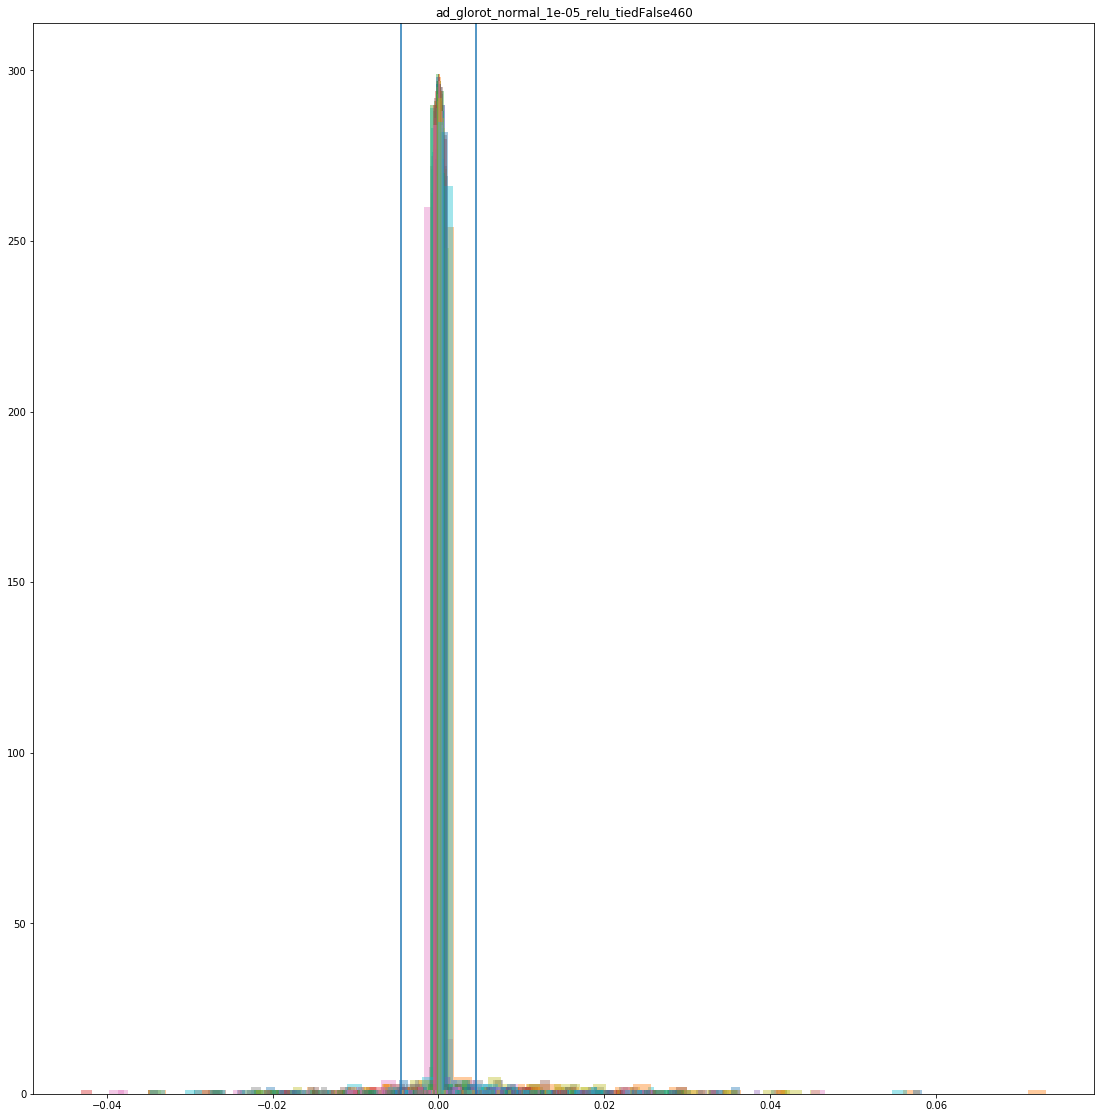

In [51]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*16 ,yd *16))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
name = 'ad_glorot_normal_1e-05_relu_tiedFalse460'
model_temp = model_dict[name]
for node in range(0,300):
    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
    ax=ax,
    hist=True,
    kde=False,
    rug=False)
ax.axvline(x = np.std(model_temp.weights)*2.5)
ax.axvline(x = np.std(model_temp.weights)*-2.5)
ax.set(title = name)
#ax.set_yscale('log')



In [ ]:
fig.savefig('single_weight_dist_skewed.png')

In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
                model_temp = model_dict_seq[name]
                for node in range(0,300):
                    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
                        ax=ax[xi,yi],
                        hist=True,
                        kde=False,
                        rug=False)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*2.5)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*-2.5)
                ax[xi,yi].set(title = name)
                xi = xi+1
        yi=yi+1


In [ ]:
fig.savefig('weight_dist_seq.png')

In [ ]:
### Signature sizes

[Text(9.125, 0.5, '# Nodes'),
 Text(0.5, 15.0, '# HW genes'),
 Text(0.5, 1, 'tf_adage')]

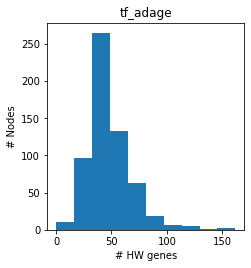

In [102]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

name = 'tf_adage'
model_temp = model_dict[name]
ax.hist(model_temp.hw_genes_all.sum(0))
ax.set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
#ax.set_yscale('log')


In [ ]:
fig.savefig('sig_sizes_adage.png')

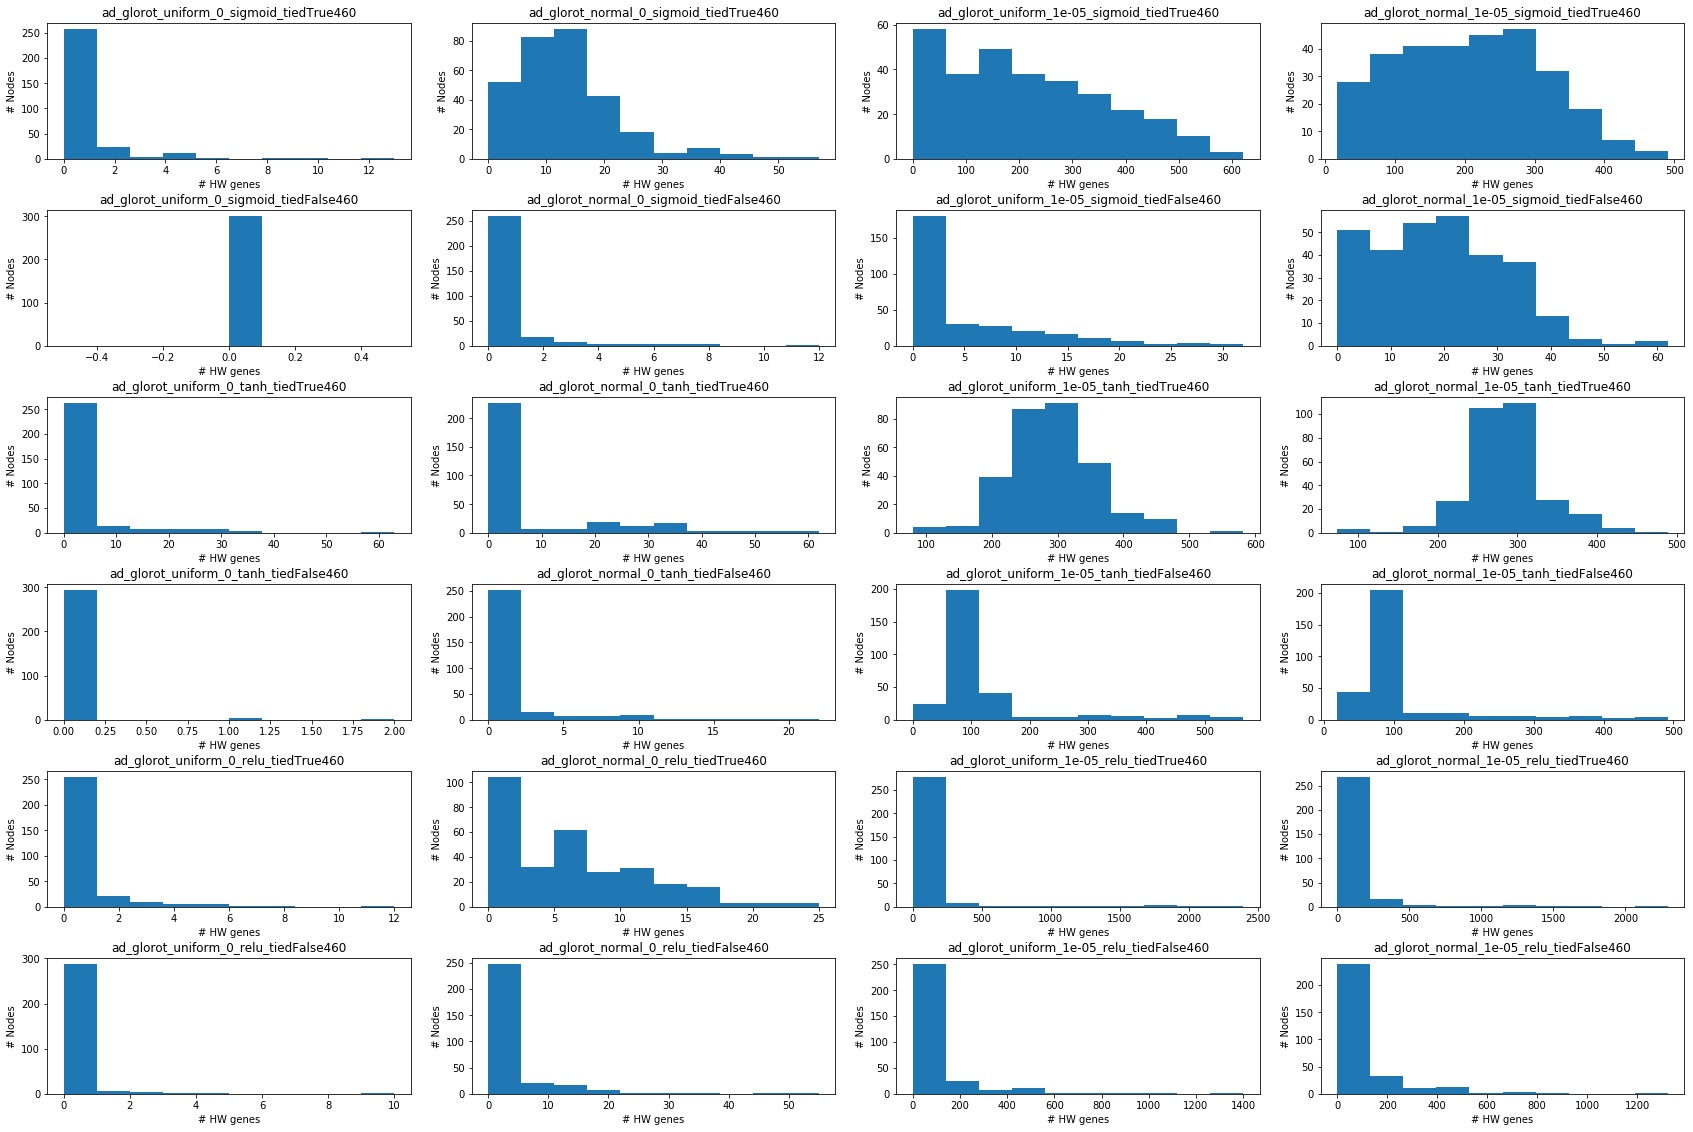

In [57]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].hist(model_temp.hw_genes.sum(0))
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                xi = xi+1
        yi=yi+1


    

In [ ]:
fig.savefig('sig_sizes_array.png')

[Text(9.125, 0.5, '# Nodes'),
 Text(0.5, 15.0, '# HW genes'),
 Text(0.5, 1, 'tf_adage')]

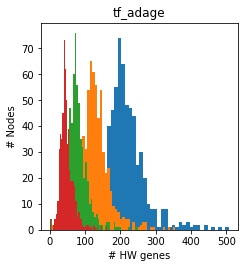

In [103]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
name = 'tf_adage'
model_temp = model_dict[name]
for c in [1.75,2,2.25,2.5]:
    model_temp.set_hwg_cutoff(c)
    ax.hist(model_temp.hw_genes_all.sum(0), bins=50)
ax.set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
#ax.set_yscale('log')



In [ ]:
fig.savefig('hwgs_grad_adage.png')

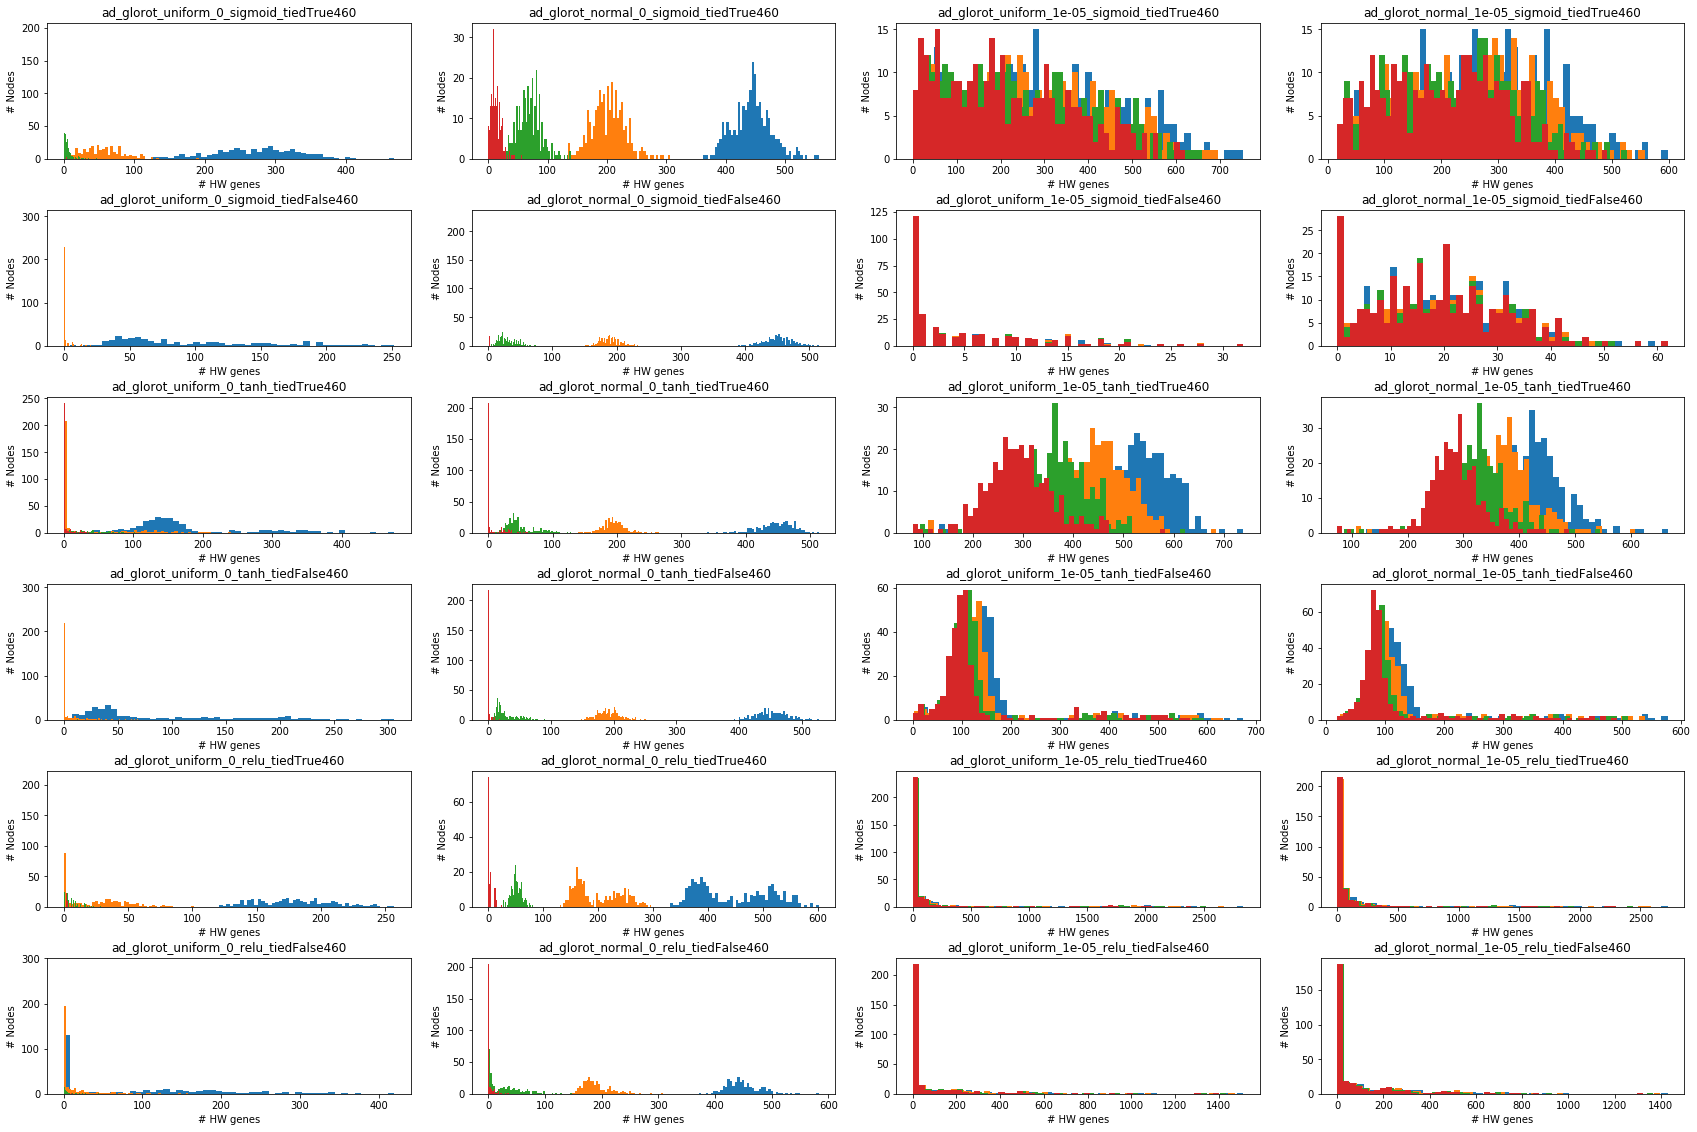

In [60]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                #ax[xi,yi].set_xscale('log')
                for c in [1.75,2,2.25,2.5]:
                    model_temp.set_hwg_cutoff(c)
                    ax[xi,yi].hist(model_temp.hw_genes.sum(0), bins=50)

                xi = xi+1
        yi=yi+1

In [ ]:
fig.savefig('hwgs_grad_array.png')

*Takeaway*: TF ADAGE may have a wider range of distributions and one *curious" node, though it is hard to say which distribution is "better" without looking at the genes themselves.

### 3. Node KEGG and GO enrichemnts

One of the primary ways we assess ADAGE models is enrichment analyses of each node for KEGG and GO pathways. Based on ADAGE, ADAGE2 and eADAGE we expect over three-quarters of the KEGG pathways to be enriched in at least one node and about half of nodes to be have enrichemnt for at least one KEGG pathway.

In [112]:
model_dict['tf_adage'].set_hwg_cutoff(2.5)
model_dict['tf_adage'].set_reg('node_interpretation/regulons_format.txt')
#model_dict[m].set_go('node_interpretation/regulons_format.txt')

,Regulon,Anr_regulon,PhoB_regulon,PvdR_regulon,PchR_regulon,AlgU_regulon,LasR_regulon,RhlR_regulon,PqsR_regulon,QscR_regulon,VreI_regulon
0,4.709350,7.751267,0.854906,12.117012,2.272795,1.799518,0.703028,0.392138,2.143654,8.600160,1.434043
1,4.358693,0.499701,0.490322,1.800917,1.942702,1.013102,0.377483,0.225077,0.670775,0.105111,1.135859
2,5.325536,3.051244,0.603320,2.716854,2.866349,0.364276,0.516656,0.787832,3.654475,9.471000,1.991735
3,5.254077,1.152198,1.593672,2.647723,2.796863,0.327877,18.095144,3.668061,9.881495,19.710989,1.925405
4,5.443319,1.310983,3.488575,2.831144,2.981172,0.428360,4.926666,0.875319,2.191071,10.550106,4.927604
...,...,...,...,...,...,...,...,...,...,...,...
595,5.325536,10.787093,4.967311,2.716854,2.866349,2.233795,1.499811,0.787832,5.624612,0.516319,4.697263
596,4.932494,2.359278,2.232509,2.338918,2.486112,0.188831,1.937869,4.478694,0.474199,1.809032,1.631885
597,4.251925,2.495871,0.102574,1.703336,4.419290,0.151205,0.720518,1.366327,0.563366,5.448425,1.048845
598,4.632389,0.677867,0.766548,2.055020,2.199758,0.890621,6.317501,5.028026,0.986484,1.024386,3.381904


In [ ]:

for m in model_dict:
    model_dict[m].set_hwg_cutoff(2.5)
    model_dict[m].set_op('node_interpretation/operons_format.txt')
    model_dict[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    model_dict[m].set_go('node_interpretation/manual_GO_BP_terms.txt') 
    model_dict[m].set_reg('node_interpretation/regulons_format.txt')
  


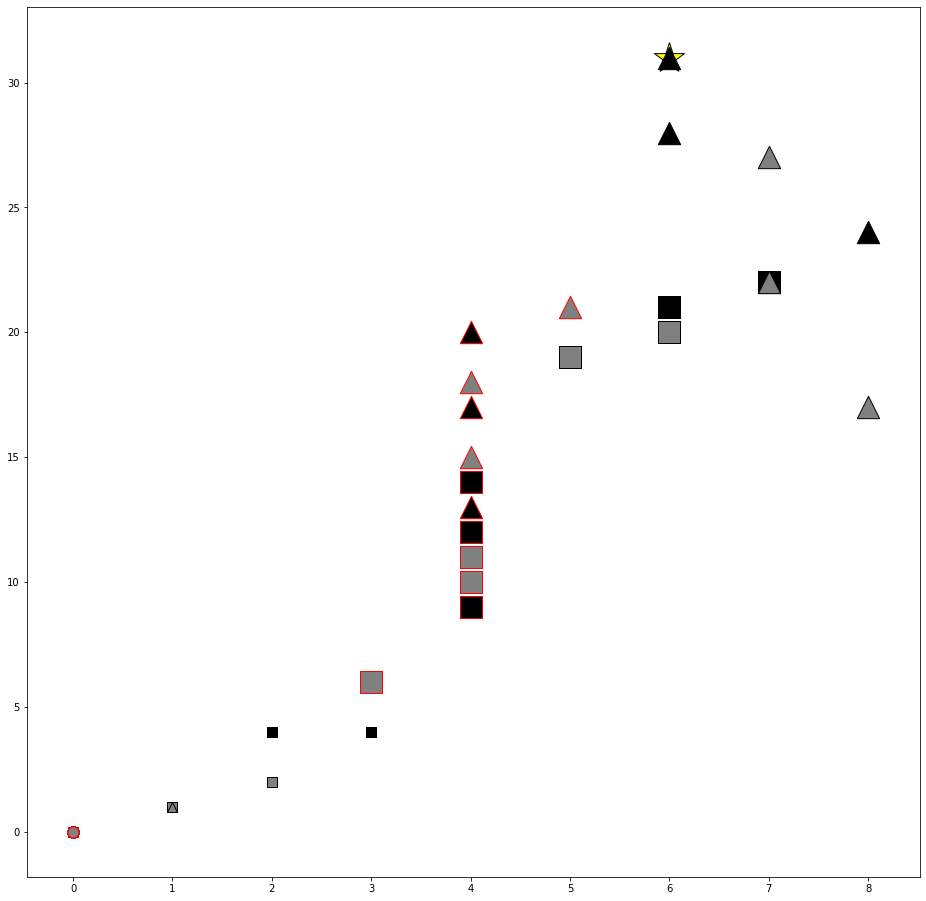

In [123]:
plimk=30
plimg=30
plimr=30
plimo=30
xd=4
yd=4
fig, ax = plt.subplots(xd,yd,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

x = ((model_dict['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[1,2].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

x = ((model_dict['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[2,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

x = ((model_dict['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[2,2].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(3):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[1,2].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[2,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                    y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[2,2].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)

                ec='red'
            mi = mi+1
        s=500
    c = 'grey'



In [161]:
total_kegg = []
node_rep = []
names = []
for m in model_d:
    total_kegg.append(((model_d[m].kegg_ps > 10).sum(0) > 0).sum())
    node_rep.append(((model_d[m].kegg_ps > 10).sum(1) > 0).sum())
    names.append(m)
    #print(m + '\n\t' + str(((model_d[m].kegg_ps > 10).sum(0) > 0).sum()) + '\t' + str(((model_d[m].kegg_ps > 10).sum(1) > 0).sum()))
    

fig, ax = plt.subplots()
ax.scatter(total_kegg, node_rep)

i=0
for x,y in zip(total_kegg, node_rep):
    label = names[i]
    if(i < 24):
        ax.annotate(label,(x,y))
    i = i+1
ax.set_xlabel('# KEGG Pathways represented', fontsize=15)
ax.set_ylabel('# Nodes with Pathways', fontsize=15)


NameError: name 'model_d' is not defined

In [162]:
model_temp = model_dict['tf_adage']

hw_gene_lists = []
for n in range(model_temp.hw_genes.shape[1]):
    genes_temp = ['node'+str(n)]
    weights_temp = [1]
    for g in range(model_temp.hw_genes.shape[0]):
        if(model_temp.hw_genes[g,n]):
            #print(g)
            genes_temp.append(model_temp.compendium.index[g])
            weights_temp.append(model_temp.weights[g,n])
    genes_temp_sorted = [x for _,x in sorted(zip(weights_temp, genes_temp), reverse=True)]
    hw_gene_lists.append(genes_temp_sorted)
    

In [ ]:
hw_gene_lists[1]

In [ ]:
#write_data('test_hwgs.csv', hw_gene_lists)
with open("adage_hwgs.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(hw_gene_lists)

In [ ]:
model_temp = model_dict['tf_adage']

hw_gene_lists = []
for n in range(model_temp.hw_genes.shape[1]):
    genes_temp = ['node'+str(n)]
    weights_temp = [1]
    for g in range(model_temp.hw_genes.shape[0]):
        if(model_temp.hw_genes[g,n]):
            #print(g)
            genes_temp.append(model_temp.compendium.index[g])
            weights_temp.append(model_temp.weights[g,n])
    genes_temp_sorted = [x for _,x in sorted(zip(weights_temp, genes_temp), reverse=True)]
    hw_gene_lists.append(genes_temp_sorted)
hw_gene_lists[1]
#write_data('test_hwgs.csv', hw_gene_lists)
with open("adage_hwgs.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(hw_gene_lists)

In [ ]:
total_kegg = []
node_rep = []
names = []
for m in model_d:
    total_kegg.append(((model_d[m].kegg_ps > 10).sum(0) > 0).sum())
    node_rep.append(((model_d[m].kegg_ps > 10).sum(1) > 0).sum())
    names.append(m)
    #print(m + '\n\t' + str(((model_d[m].kegg_ps > 10).sum(0) > 0).sum()) + '\t' + str(((model_d[m].kegg_ps > 10).sum(1) > 0).sum()))
    

fig, ax = plt.subplots()
ax.scatter(total_kegg, node_rep)

i=0
for x,y in zip(total_kegg, node_rep):
    label = names[i]
    if(i < 24):
        ax.annotate(label,(x,y))
    i = i+1
ax.set_xlabel('# KEGG Pathways represented', fontsize=15)
ax.set_ylabel('# Nodes with Pathways', fontsize=15)


In [ ]:
model_dict

KeyError: 'ad_glorot_uniform_0_sigmoid_tiedTrue460'

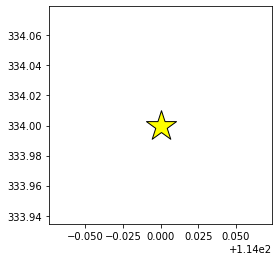

In [114]:
fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].kegg_ps > 10).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > 10).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(10):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict[name]
                    x = ((model_temp.regs_ps > 10).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > 10).sum(1) > 0).sum()
                    ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    #ax[xi,yi].set(title = m, xlabel = '# HW genes', ylabel = '# Nodes')
                    #xi = xi+1
                ec='red'
            mi = mi+1
        s=500
    c = 'grey'




In [ ]:

for m in model_dict:
    model_dict[m].set_hwg_cutoff(2.5)
    model_dict[m].set_go('node_interpretation/regulons_format.txt')
#model_dict['tf_adage'].set_hwg_cutoff(2.5)
#model_dict['tf_adage'].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt')    




In [ ]:
plim = 30

fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].go_ps > plim).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plim).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(10):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict[name]
                    x = ((model_temp.go_ps > plim).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plim).sum(1) > 0).sum()
                    ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    ax.set(title = m, xlabel = '# Regulons', ylabel = '# Nodes')

                    #xi = xi+1
                ec='red'
            mi = mi+1
        s=500
    c = 'grey'


In [ ]:

fig.savefig('regulon_summary_array.png')

In [ ]:

fig, ax = plt.subplots(len(model_d), 2,figsize=(10,3*len(model_d)))
fig.tight_layout(pad=3.0)

#ax[0].plot(list(range(0,500)), tf_adage.loss,'go-', linewidth=1, markersize=2)
#ax[0].set(title = 'TF', xlabel = 'Epochs', ylabel = 'Cost')
i = 0
for m in model_d:
    ax[i,0].hist((model_d[m].kegg_ps > 10).sum(0))
    ax[i,0].set(title = m, xlabel = '# Nodes per Pathway', ylabel = '# Pathways')
    ax[i,1].hist((model_d[m].kegg_ps > 10).sum(1))
    ax[i,1].set(title = m, xlabel = '# Pathways in Node', ylabel = '# Nodes')
    i = i+1

In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for i in inits:
    for l in L1_norm:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].hist((model_temp.kegg_ps > 10).sum(0))
                ax[xi,yi].set(title = name, xlabel = '# Nodes per Pathway', ylabel = '# Pathways')
                xi = xi+1
        yi=yi+1



In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for i in inits:
    for l in L1_norm:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].hist((model_temp.kegg_ps > 10).sum(0))
                ax[xi,yi].set(title = name, xlabel = '# Nodes per Pathway', ylabel = '# Pathways')
                xi = xi+1
        yi=yi+1


yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for i in inits:
    for l in L1_norm:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].hist((model_temp.kegg_ps > 10).sum(1))
                ax[xi,yi].set(title = name, xlabel = '# Pathways in Node', ylabel = '# Nodes')
                xi = xi+1
        yi=yi+1



In [ ]:
fig.savefig('kegg_details.png')

*Takeaway*: This is where the red flag really stands out. Using Keras there was nearly no enrichemnt for any pathways in any nodes at all, perhaps what one would expect using randomly permuted weights? It could be nice to get a good pre- and post- training picture, but I think it is safe to say something has missed the boat.

## seqADAGE

Although the above comparison suggests an error in the Keras workflow, below I have outlines the training of a Keras model on the RNAseq compendium in anticipation of an re-iterative analysis going forward with promising edits.

In [ ]:
#adage_comp = pandas.read_csv('data_files/ADAGE_compendium.csv')
seq_comp = np.loadtxt(open('data_files/refine_bio_seq_clean.csv', "rb"),delimiter=',',skiprows = 1)
seq_gene_num = np.size(seq_comp, 0)
seq_samp_num = np.size(seq_comp, 1)
print(seq_gene_num, seq_samp_num)

In [ ]:
fig = sns.distplot(seq_comp)

In [ ]:
fig.figure.savefig('seq_dist01.png')

In [ ]:
seq_adage = run_model.run_model('data_files/refine_bio_seq_with_gene_names.csv',seed=460,kl1=0,act='relu', tied=True, epochs=500, init = 'glorot_normal')

In [ ]:
model_d = {
    "tf_adage": tf_adage,
    "keras" : keras_adage,
    "keras_L1" : keras_adage_L1,
    'seq_adage': seq_adage
}

for m in model_d:
    print(model_d[m])

In [ ]:
model_dict_seq = {
    "tf_adage": tf_adage
}

for i in inits:
    #print(i)
    for l in L1_norm:
        #print(l)
        for a in act_fun:
            #print(a)
            for t in tied:
                m = run_model.run_model('data_files/refine_bio_seq_01_with_names.csv',seed=460,kl1=l, act = a, tied = t, epochs=500, init=i, batch_size=100)
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                print(name)
                model_dict_seq[name] = m

In [164]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict_seq = {
    "tf_adage": tf_adage
}

for i in inits:
    #print(i)
    for l in L1_norm:
        #print(l)
        for a in act_fun:
            #print(a)
            for t in tied:
                for s in range(3):
                    seed = str(460 + s)
                    #print(t)
                    #m = run_model.run_model('data_files/train_set_normalized.csv',seed=460,kl1=l, act = a, tied = t, epochs=500, init=i)
                    prefix = 'data_files/refine_bio_seq_01_with_names_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:500_tied:' + str(t) + '_batch:' + str(batch)
                    #print(prefix)
                    weights_temp = np.array(pandas.read_csv('outputs/' + prefix + '_en_weights.csv', header = None))
                    loss_temp = np.array(pandas.read_csv('outputs/' + prefix + '_loss.csv', header = None))
                    val_loss_temp = np.array(pandas.read_csv('outputs/' + prefix + '_val_loss.csv', header = None))
                    adage_temp = Adage.Adage(tf_adage.autoencoder, tf_adage.history, tf_adage.compendium)
                    adage_temp.weights = weights_temp
                    adage_temp.loss = loss_temp[0]
                    adage_temp.val_loss = val_loss_temp[0]
                    adage_temp.set_hwg_cutoff(2.5)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_dict_seq[name] = adage_temp
          
                    


In [165]:
model_dict_seq

{'tf_adage': <Adage.Adage at 0x7f6bffe070d0>,
 'ad_glorot_uniform_0_sigmoid_tiedTrue460': <Adage.Adage at 0x7f6ca14fce50>,
 'ad_glorot_uniform_0_sigmoid_tiedTrue461': <Adage.Adage at 0x7f6ca14fc090>,
 'ad_glorot_uniform_0_sigmoid_tiedTrue462': <Adage.Adage at 0x7f6c41b93510>,
 'ad_glorot_uniform_0_sigmoid_tiedFalse460': <Adage.Adage at 0x7f6c48c23cd0>,
 'ad_glorot_uniform_0_sigmoid_tiedFalse461': <Adage.Adage at 0x7f6b994f4e50>,
 'ad_glorot_uniform_0_sigmoid_tiedFalse462': <Adage.Adage at 0x7f6ca80164d0>,
 'ad_glorot_uniform_0_tanh_tiedTrue460': <Adage.Adage at 0x7f6c41b98ad0>,
 'ad_glorot_uniform_0_tanh_tiedTrue461': <Adage.Adage at 0x7f6c41b98750>,
 'ad_glorot_uniform_0_tanh_tiedTrue462': <Adage.Adage at 0x7f6c073d31d0>,
 'ad_glorot_uniform_0_tanh_tiedFalse460': <Adage.Adage at 0x7f6c073d3b10>,
 'ad_glorot_uniform_0_tanh_tiedFalse461': <Adage.Adage at 0x7f6c073d3c90>,
 'ad_glorot_uniform_0_tanh_tiedFalse462': <Adage.Adage at 0x7f6c073d3b50>,
 'ad_glorot_uniform_0_relu_tiedTrue460': <

In [ ]:
model_d = model_dict_seq

In [ ]:

fig, ax = plt.subplots(len(model_d), 1,figsize=(6,3*len(model_d)))
fig.tight_layout(pad=3.0)

#ax[0].plot(list(range(0,500)), tf_adage.loss,'go-', linewidth=1, markersize=2)
#ax[0].set(title = 'TF', xlabel = 'Epochs', ylabel = 'Cost')
i = 0
for m in model_d:
    ax[i].plot(list(range(0,500)), model_d[m].loss, 'go-', linewidth=1, markersize=2, color = 'orange')
    ax[i].set(title = m, xlabel = 'Epochs', ylabel = 'Loss')
    i = i+1

In [ ]:
fig.savefig('seq_loss.png')

In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
                model_temp = model_dict_seq[name]
                ax[xi,yi].plot(list(range(0,500)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
                ax[xi,yi].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
                xi = xi+1
        yi=yi+1



In [ ]:
fig.savefig('loss_seq.png')

In [ ]:
fig, ax = plt.subplots(len(model_d), 1,figsize=(6,3*len(model_d)))
fig.tight_layout(pad=3.0)


i = 0
for m in model_d:
    #ax[i].sns.distplot(list(range(0,500)), model_d[m].weights[0], 'go-', linewidth=1, markersize=2, color = 'orange')
    ax[i].set(title = m, xlabel = 'Weight', ylabel = 'Density')
    for node in range(0,300):
        sns.distplot(model_d[m].weights[node],
            ax=ax[i],
            hist=False,
            kde=True,
            rug=False)
    i = i+1

In [ ]:
fig.savefig('seq_weight_dist.png')

In [ ]:
fig, ax = plt.subplots(len(model_d), 1,figsize=(6,3*len(model_d)))
fig.tight_layout(pad=3.0)

#ax[0].plot(list(range(0,500)), tf_adage.loss,'go-', linewidth=1, markersize=2)
#ax[0].set(title = 'TF', xlabel = 'Epochs', ylabel = 'Cost')
i = 0
for m in model_d:
    ax[i].hist(model_d[m].hw_genes.sum(0))
    ax[i].set(title = m, xlabel = '# HW genes', ylabel = '# Nodes')
    i = i+1

In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
                model_temp = model_dict_seq[name]
                for node in range(0,300):
                    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
                        ax=ax[xi,yi],
                        hist=True,
                        kde=False,
                        rug=False)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*2.5)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*-2.5)
                ax[xi,yi].set(title = name)
                xi = xi+1
        yi=yi+1



In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
                model_temp = model_dict_seq[name]
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                #ax[xi,yi].set_xscale('log')
                for c in [1.75,2,2.25,2.5]:
                    model_temp.set_hwg_cutoff(c)
                    ax[xi,yi].hist(model_temp.hw_genes.sum(0), bins=50)

                xi = xi+1
        yi=yi+1

In [ ]:
fig.savefig('seq_sig_sizes.png')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].kegg_ps > 10).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > 10).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(10):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict_seq[name]
                    x = ((model_temp.kegg_ps > 10).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > 10).sum(1) > 0).sum()
                    ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    #ax[xi,yi].set(title = m, xlabel = '# HW genes', ylabel = '# Nodes')
                    #xi = xi+1
                ec='red'
            mi = mi+1
        s=500
    c = 'grey'


In [ ]:

for m in model_d:
    model_d[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt')

In [ ]:
for m in model_dict_seq:
    model_dict_seq[m].set_hwg_cutoff(2.5)
    model_dict_seq[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].kegg_ps > 10).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > 10).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '.', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(1):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) 
                    print(name)
                    model_temp = model_dict_seq[name]
                    x = ((model_temp.kegg_ps > 10).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > 10).sum(1) > 0).sum()
                    ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    #ax[xi,yi].set(title = m, xlabel = '# HW genes', ylabel = '# Nodes')
                    #xi = xi+1
                ec='red'
            mi = mi+1
        s=200
    c = 'grey'



In [ ]:
fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].kegg_ps > 10).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > 10).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '.', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi=0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:

                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) 
                print(name)
                model_temp = model_dict_seq[name]
                x = ((model_temp.kegg_ps > 10).sum(0) > 0).sum()
                y = ((model_temp.kegg_ps > 10).sum(1) > 0).sum()
                ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    #ax[xi,yi].set(title = m, xlabel = '# HW genes', ylabel = '# Nodes')
                xi = xi+1
                ec='red'
            mi = mi+1
        s=500
    c = 'grey'

In [ ]:
total_kegg = []
node_rep = []
names = []
for m in model_d:
    total_kegg.append(((model_d[m].kegg_ps > 10).sum(0) > 0).sum())
    node_rep.append(((model_d[m].kegg_ps > 10).sum(1) > 0).sum())
    names.append(m)
    #print(m + '\n\t' + str(((model_d[m].kegg_ps > 10).sum(0) > 0).sum()) + '\t' + str(((model_d[m].kegg_ps > 10).sum(1) > 0).sum()))
    

fig, ax = plt.subplots()
ax.scatter(total_kegg, node_rep)

i=0
for x,y in zip(total_kegg, node_rep):
    label = names[i]
    if(i < 24):
        ax.annotate(label,(x,y))
    i = i+1
ax.set_xlabel('# KEGG Pathways represented', fontsize=15)
ax.set_ylabel('# Nodes with Pathways', fontsize=15)



In [ ]:
fig.savefig('seq_kegg_summary.png')

In [ ]:

fig, ax = plt.subplots(len(model_d), 2,figsize=(8,3*len(model_d)))
fig.tight_layout(pad=3.0)

#ax[0].plot(list(range(0,500)), tf_adage.loss,'go-', linewidth=1, markersize=2)
#ax[0].set(title = 'TF', xlabel = 'Epochs', ylabel = 'Cost')
i = 0
for m in model_d:
    ax[i,0].hist((model_d[m].kegg_ps > 10).sum(0))
    ax[i,0].set(title = m, xlabel = '# Nodes per Pathway', ylabel = '# Pathways')
    ax[i,1].hist((model_d[m].kegg_ps > 10).sum(1))
    ax[i,1].set(title = m, xlabel = '# Pathways in Node', ylabel = '# Nodes')
    i = i+1

In [ ]:
fig.savefig('seq_kegg_details.png')

In [ ]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict = {
    "tf_adage": tf_adage
}

for seed in range(10):
    for i in inits:
    #print(i)
        for l in L1_norm:
        #print(l)
            for a in act_fun:
            #print(a)
                for t in tied:
                    m = run_model.run_model('data_files/refine_bio_seq_01_with_names.csv',seed=seed+460,kl1=l, act = a, tied = t, epochs=500, init=i)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                    print(name)
                    model_dict_seq[name] = m
                    
for m in model_dict_seq:
    model_dict_seq[m].set_hwg_cutoff(2.5)
    model_dict_seq[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt')

In [ ]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict_seq = {
    "tf_adage": tf_adage
}

for i in inits:
    #print(i)
    for l in L1_norm:
        #print(l)
        for a in act_fun:
            #print(a)
            for t in tied:
                for s in range(10):
                    seed = str(460 + s)
                    #print(t)
                    #m = run_model.run_model('data_files/train_set_normalized.csv',seed=460,kl1=l, act = a, tied = t, epochs=500, init=i)
                    prefix = 'data_files/refine_bio_seq_01_with_names_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:500_tied:' + str(t)
                    #print(prefix)
                    weights_temp = np.array(pandas.read_csv('outputs/' + prefix + '_en_weights.csv', header = None))
                    loss_temp = np.array(pandas.read_csv('outputs/' + prefix + '_loss.csv', header = None))
                    val_loss_temp = np.array(pandas.read_csv('outputs/' + prefix + '_val_loss.csv', header = None))

                    adage_temp = Adage.Adage(keras_adage.autoencoder, keras_adage.history, keras_adage.compendium)
                    adage_temp.weights = weights_temp
                    adage_temp.loss = loss_temp[0]
                    adage_temp.val_loss = val_loss_temp[0]
                    adage_temp.set_hwg_cutoff(2.5)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    print(name)
                    model_dict_seq[name] = adage_temp
                    
model_dict_seq

In [ ]:
for m in model_dict_seq:
    model_dict_seq[m].set_hwg_cutoff(2.5)
    model_dict_seq[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt')

In [ ]:
model_temp = model_dict_seq['ad_glorot_uniform_0_sigmoid_tiedTrue460']

hw_gene_lists = []
for n in range(model_temp.hw_genes.shape[1]):
    genes_temp = ['node'+str(n)]
    weights_temp = [1]
    for g in range(model_temp.hw_genes.shape[0]):
        if(model_temp.hw_genes[g,n]):
            #print(g)
            genes_temp.append(model_temp.compendium.index[g])
            weights_temp.append(model_temp.weights[g,n])
    genes_temp_sorted = [x for _,x in sorted(zip(weights_temp, genes_temp), reverse=True)]
    hw_gene_lists.append(genes_temp_sorted)
    

In [ ]:
#write_data('test_hwgs.csv', hw_gene_lists)
with open("group8_seq_hwgs.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(hw_gene_lists)

In [ ]:

model_dict_seq

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].kegg_ps > 10).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > 10).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(10):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict_seq[name]
                    x = ((model_temp.kegg_ps > 10).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > 10).sum(1) > 0).sum()
                    ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    #ax[xi,yi].set(title = m, xlabel = '# HW genes', ylabel = '# Nodes')
                    #xi = xi+1
                ec='red'
            mi = mi+1
        s=500
    c = 'grey'




In [ ]:
for m in model_dict:
    model_dict_seq[m].set_hwg_cutoff(2.5)
    model_dict_seq[m].set_go('node_interpretation/regulons_format.txt')
#model_dict['tf_adage'].set_hwg_cutoff(2.5)
#model_dict['tf_adage'].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt')    


In [ ]:
plim = 8
fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].go_ps > plim).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plim).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(10):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict_seq[name]
                    x = ((model_temp.go_ps > plim).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plim).sum(1) > 0).sum()
                    ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    #ax[xi,yi].set(title = m, xlabel = '# HW genes', ylabel = '# Nodes')
                    #xi = xi+1
                ec='red'
            mi = mi+1
        s=500
    c = 'grey'


In [ ]:
fig.savefig('regulon_summary_seq.png')

## seqADAGE

Although the above comparison suggests an error in the Keras workflow, below I have outlines the training of a Keras model on the RNAseq compendium in anticipation of an re-iterative analysis going forward with promising edits.

In [ ]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict2 = {
    "tf_adage": tf_adage
}
model_dict_seq2 = {
    "tf_adage": tf_adage
}

for seed in range(10):
    for i in inits:
    #print(i)
        for l in L1_norm:
        #print(l)
            for a in act_fun:
            #print(a)
                for t in tied:
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(seed)
                    print(name)
                    mseq = run_model.run_model('data_files/refine_bio_seq_clean_with_names.csv',seed=seed+560,kl1=l, act = a, tied = t, epochs=500, init=i)
                    marr = run_model.run_model('data_files/train_set_normalized.csv',seed=seed+560,kl1=l, act = a, tied = t, epochs=500, init=i)

                    model_dict2[name] = marr
                    model_dict_seq2[name] = mseq
                

In [19]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]
seq_temp = run_model.run_model('data_files/refine_bio_seq_clean_with_names.csv',960,kl1=0, act = 'tanh', tied = True, epochs=1, init='glorot_normal')
arr_temp = run_model.run_model('data_files/train_set_normalized.csv',960,kl1=0, act = 'tanh', tied = True, epochs=1, init='glorot_normal')
tf_adage = Adage.Adage(arr_temp.autoencoder, arr_temp.history, arr_temp.compendium)
tf_weights = np.array(pd.read_csv('outputs/ADAGE_OG_weights.csv', header = None))
tf_cost = pd.read_csv('outputs/ADAGE_OG_cost_log.csv')
tf_adage.weights = tf_weights
tf_adage.loss = tf_cost['cost']
tf_adage.set_hwg_cutoff(2.5).shape

tensorflow
Train on 895 samples, validate on 100 samples
Epoch 1/1
895/895 [==============================] - 1s 568us/step - loss: 1.3965 - val_loss: 1.0104
tensorflow
Train on 855 samples, validate on 95 samples
Epoch 1/1
855/855 [==============================] - 1s 635us/step - loss: 1.3426 - val_loss: 0.9499


(5549, 600)

In [16]:
seq_temp.compendium

,ERR583485,ERR583486,ERR583487,ERR583488,ERR583489,ERR583490,ERR583491,ERR583492,ERR583493,ERR583494,...,SRR10856464,SRR10856465,SRR10856468,SRR10856475,SRR10856476,SRR10856477,SRR10856478,SRR10856479,SRR10856480,NA.
X,,,,,,,,,,,,,,,,,,,,,
PA0001,0.671443,0.708615,0.754896,0.692356,0.709740,0.643171,0.814958,0.813673,0.612071,0.601390,...,0.713945,0.713606,0.649205,0.656233,0.688644,0.689434,0.671596,0.681038,0.671996,0.668927
PA0002,0.475630,0.499940,0.603676,0.499238,0.563537,0.493243,0.579042,0.585886,0.461118,0.473614,...,0.639362,0.653312,0.624799,0.617239,0.651947,0.656096,0.733395,0.735548,0.636665,0.631781
PA0003,0.527891,0.578327,0.629401,0.579720,0.609309,0.594365,0.731892,0.696162,0.469088,0.481004,...,0.629865,0.629187,0.548001,0.548130,0.598767,0.602136,0.570664,0.565829,0.592751,0.581351
PA0004,0.524364,0.553934,0.654255,0.560586,0.635635,0.549134,0.697372,0.712418,0.550984,0.564737,...,0.744624,0.747036,0.693060,0.690483,0.732670,0.736854,0.728671,0.730206,0.708053,0.699519
PA0005,0.327333,0.360534,0.495376,0.407000,0.453617,0.358099,0.335235,0.380722,0.325236,0.313923,...,0.531310,0.529932,0.505435,0.501224,0.503099,0.502439,0.448920,0.508096,0.543919,0.559678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5564,0.375295,0.397557,0.385648,0.366963,0.395829,0.374039,0.398319,0.415448,0.273601,0.252365,...,0.533213,0.530416,0.447806,0.417744,0.497868,0.506976,0.455384,0.459894,0.486245,0.471133
PA5565,0.677224,0.688574,0.659348,0.580513,0.643933,0.549346,0.644655,0.652909,0.512445,0.497420,...,0.724968,0.714228,0.631686,0.620521,0.685616,0.687426,0.644645,0.649773,0.651875,0.647432
PA5566,0.166319,0.161202,0.338037,0.261451,0.326882,0.232460,0.213960,0.200833,0.176812,0.197625,...,0.346166,0.376799,0.411912,0.416786,0.331355,0.347427,0.222948,0.283338,0.451496,0.443314


In [20]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict3 = {
    "tf_adage": tf_adage
}

model_dict_seq3 = {
    "tf_adage": tf_adage
}

for i in inits:
    #print(i)
    for l in L1_norm:
        #print(l)
        for a in act_fun:
            #print(a)
            for t in tied:
                for s in range(3):
                    seed = str(560 + s)
                    #print(t)
                    #m = run_model.run_model('data_files/train_set_normalized.csv',seed=460,kl1=l, act = a, tied = t, epochs=500, init=i)
                    prefix = 'data_files/train_set_normalized_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:500_tied:' + str(t)
                    #print(prefix)
                    weights_temp = np.array(pd.read_csv('outputs/' + prefix + '_en_weights.csv', header = None))
                    loss_temp = np.array(pd.read_csv('outputs/' + prefix + '_loss.csv', header = None))
                    val_loss_temp = np.array(pd.read_csv('outputs/' + prefix + '_val_loss.csv', header = None))
                    adage_temp = Adage.Adage(tf_adage.autoencoder, tf_adage.history, tf_adage.compendium)
                    adage_temp.weights = weights_temp
                    adage_temp.loss = loss_temp[0]
                    adage_temp.val_loss = val_loss_temp[0]
                    adage_temp.set_hwg_cutoff(2.5)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_dict3[name] = adage_temp
                    
                    prefix = 'data_files/refine_bio_seq_clean_with_names_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:500_tied:' + str(t)
                    #print(prefix)
                    weights_temp = np.array(pd.read_csv('outputs/' + prefix + '_en_weights.csv', header = None))
                    loss_temp = np.array(pd.read_csv('outputs/' + prefix + '_loss.csv', header = None))
                    val_loss_temp = np.array(pd.read_csv('outputs/' + prefix + '_val_loss.csv', header = None))
                    adage_temp = Adage.Adage(seq_temp.autoencoder, seq_temp.history, seq_temp.compendium)
                    adage_temp.weights = weights_temp
                    adage_temp.loss = loss_temp[0]
                    adage_temp.val_loss = val_loss_temp[0]
                    adage_temp.set_hwg_cutoff(2.5)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_dict_seq3[name] = adage_temp
          
                    

In [181]:
for m in model_dict_seq2:
    print(m)

tf_adage
ad_glorot_uniform_0_sigmoid_tiedTrue
ad_glorot_uniform_0_sigmoid_tiedFalse
ad_glorot_uniform_0_tanh_tiedTrue
ad_glorot_uniform_0_tanh_tiedFalse
ad_glorot_uniform_0_relu_tiedTrue
ad_glorot_uniform_0_relu_tiedFalse
ad_glorot_uniform_1e-05_sigmoid_tiedTrue
ad_glorot_uniform_1e-05_sigmoid_tiedFalse
ad_glorot_uniform_1e-05_tanh_tiedTrue
ad_glorot_uniform_1e-05_tanh_tiedFalse
ad_glorot_uniform_1e-05_relu_tiedTrue
ad_glorot_uniform_1e-05_relu_tiedFalse
ad_glorot_normal_0_sigmoid_tiedTrue
ad_glorot_normal_0_sigmoid_tiedFalse
ad_glorot_normal_0_tanh_tiedTrue
ad_glorot_normal_0_tanh_tiedFalse
ad_glorot_normal_0_relu_tiedTrue
ad_glorot_normal_0_relu_tiedFalse
ad_glorot_normal_1e-05_sigmoid_tiedTrue
ad_glorot_normal_1e-05_sigmoid_tiedFalse
ad_glorot_normal_1e-05_tanh_tiedTrue
ad_glorot_normal_1e-05_tanh_tiedFalse
ad_glorot_normal_1e-05_relu_tiedTrue
ad_glorot_normal_1e-05_relu_tiedFalse
ad_glorot_uniform_0_sigmoid_tiedTrue560
ad_glorot_uniform_0_sigmoid_tiedTrue561
ad_glorot_uniform_0_sig

#### Training loss curves

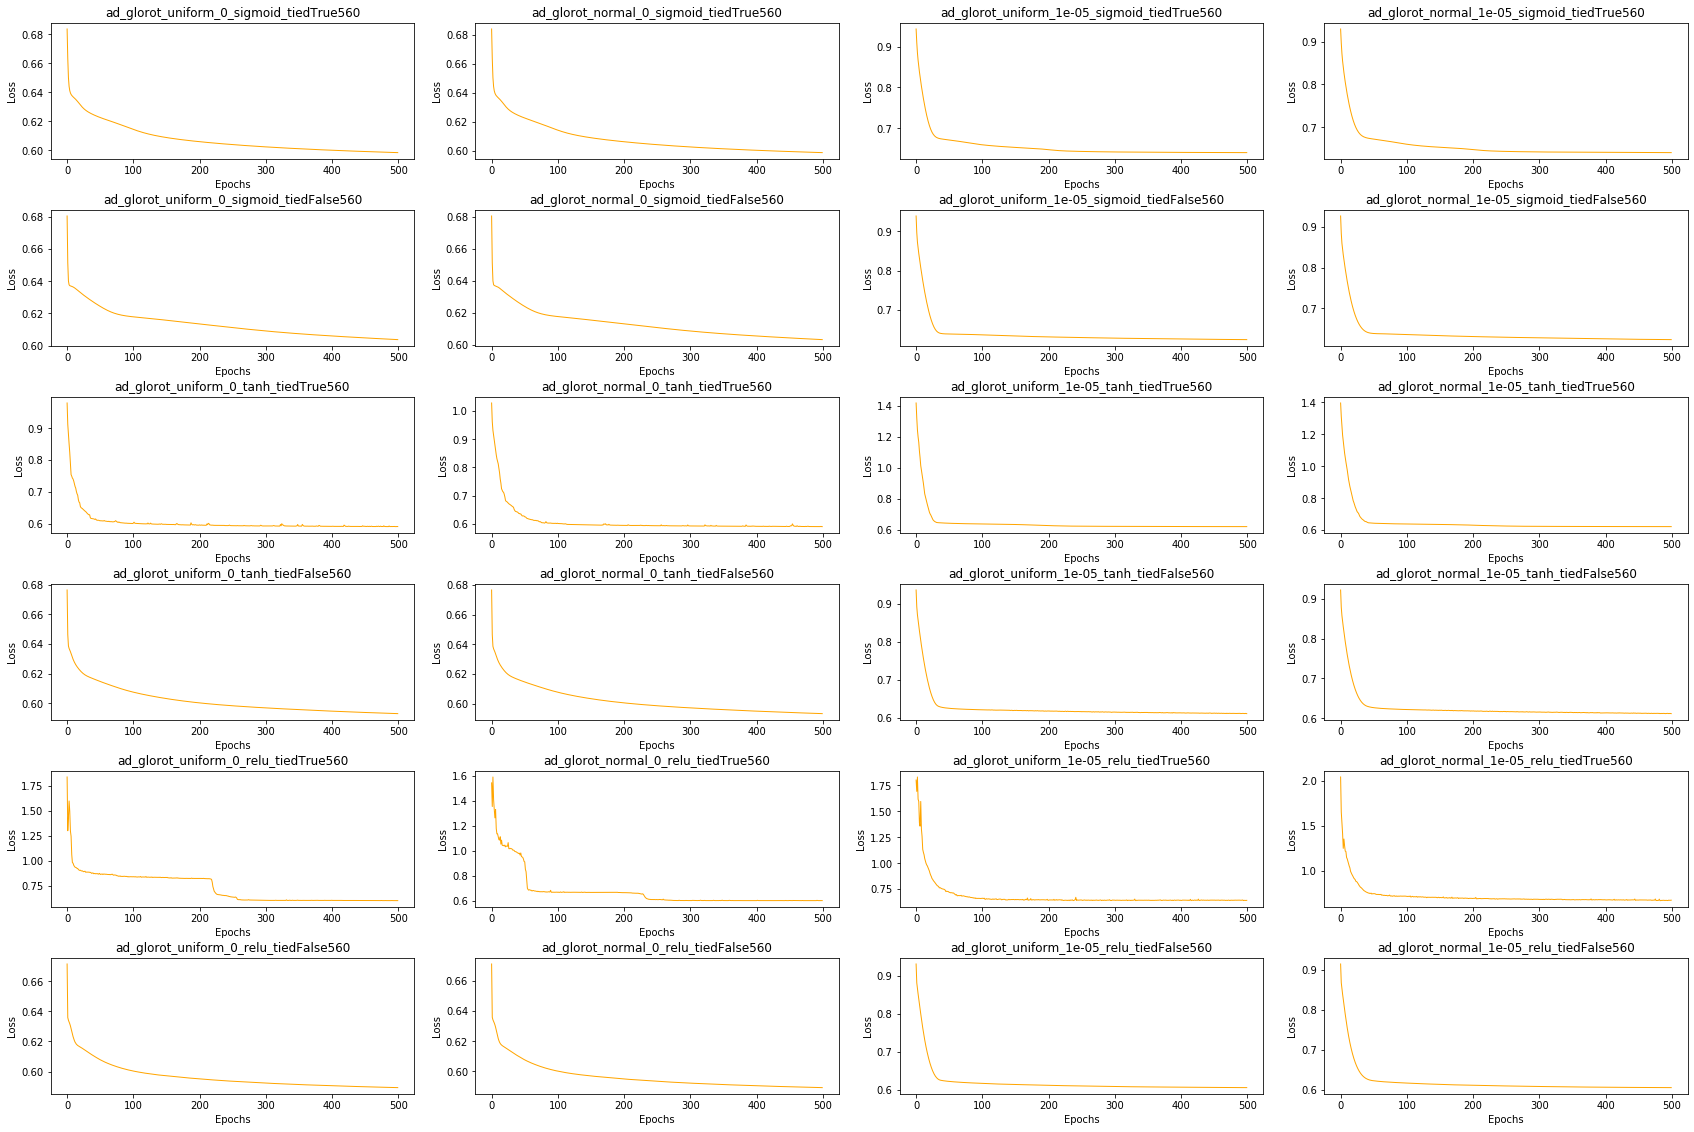

In [535]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict2[name]
                ax[xi,yi].plot(list(range(0,500)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
                ax[xi,yi].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
                xi = xi+1
        yi=yi+1


In [ ]:
fig.savefig('training_loss_array.png')

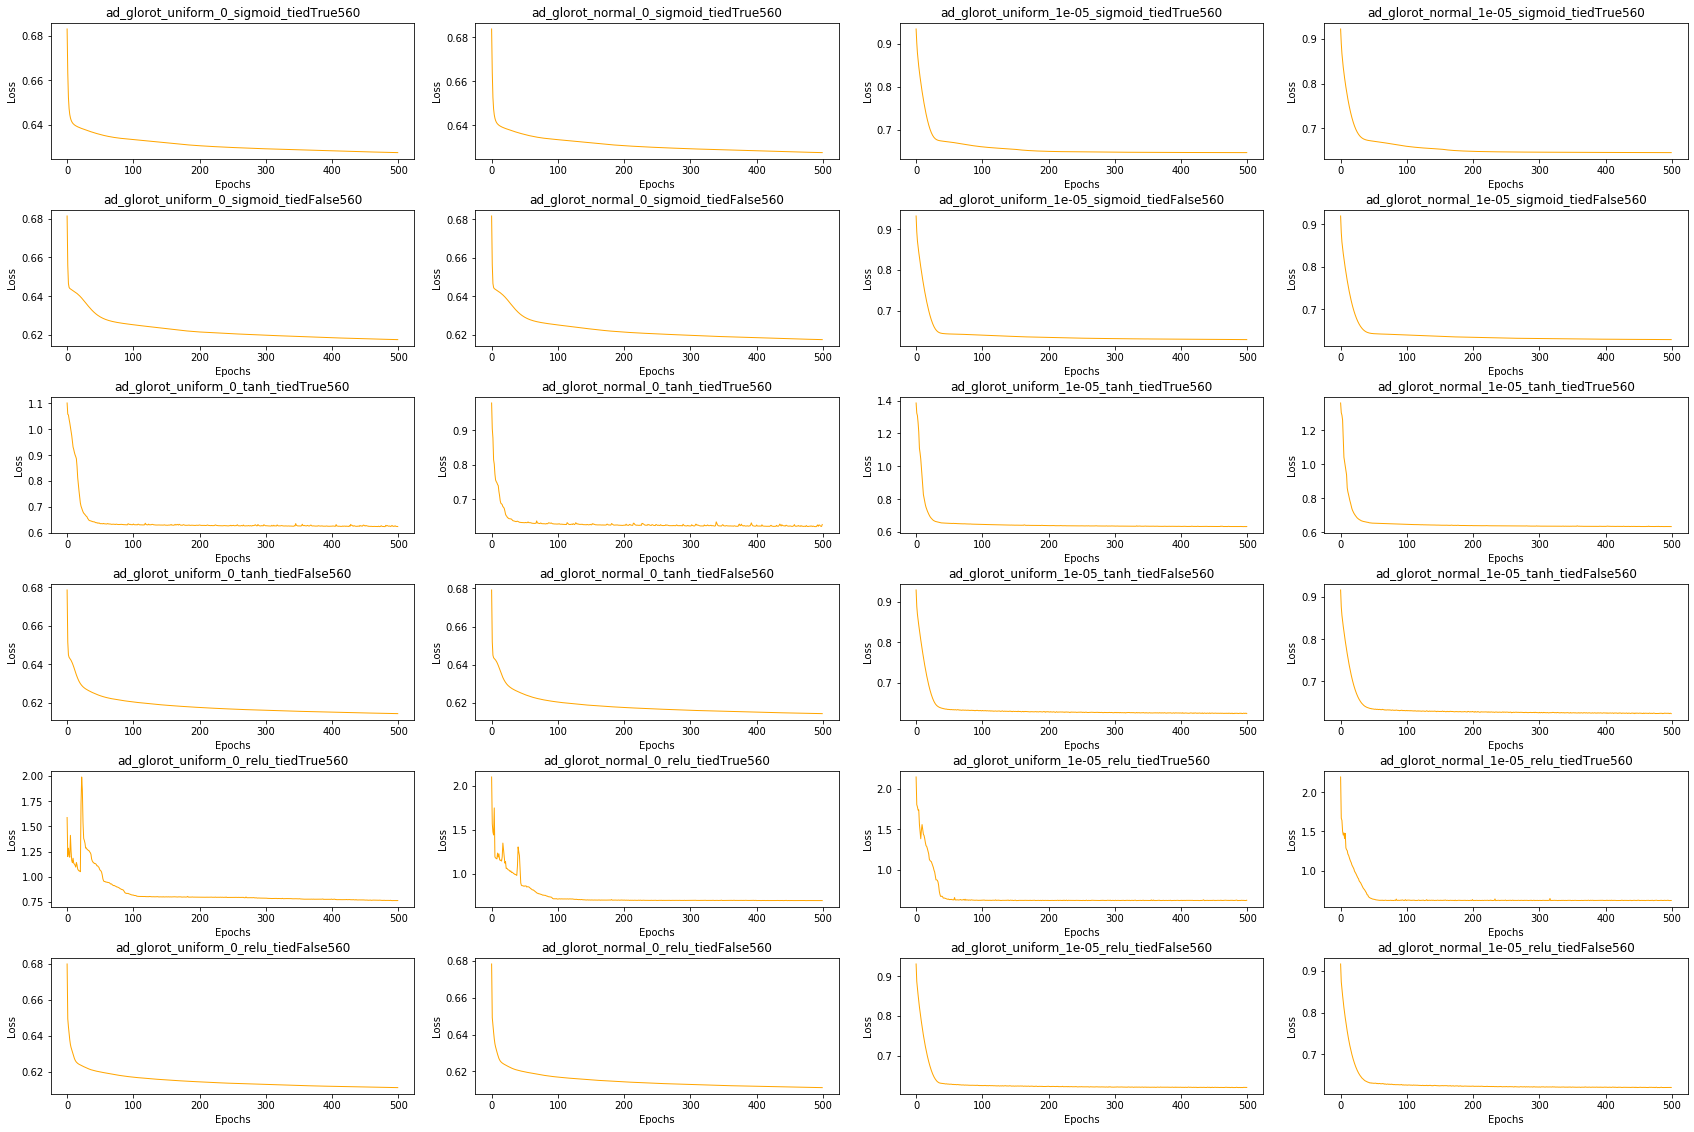

In [182]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict_seq2[name]
                ax[xi,yi].plot(list(range(0,500)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
                ax[xi,yi].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
                xi = xi+1
        yi=yi+1


In [ ]:
fig.savefig('training_loss_seq.png')

#### Node weight distributions

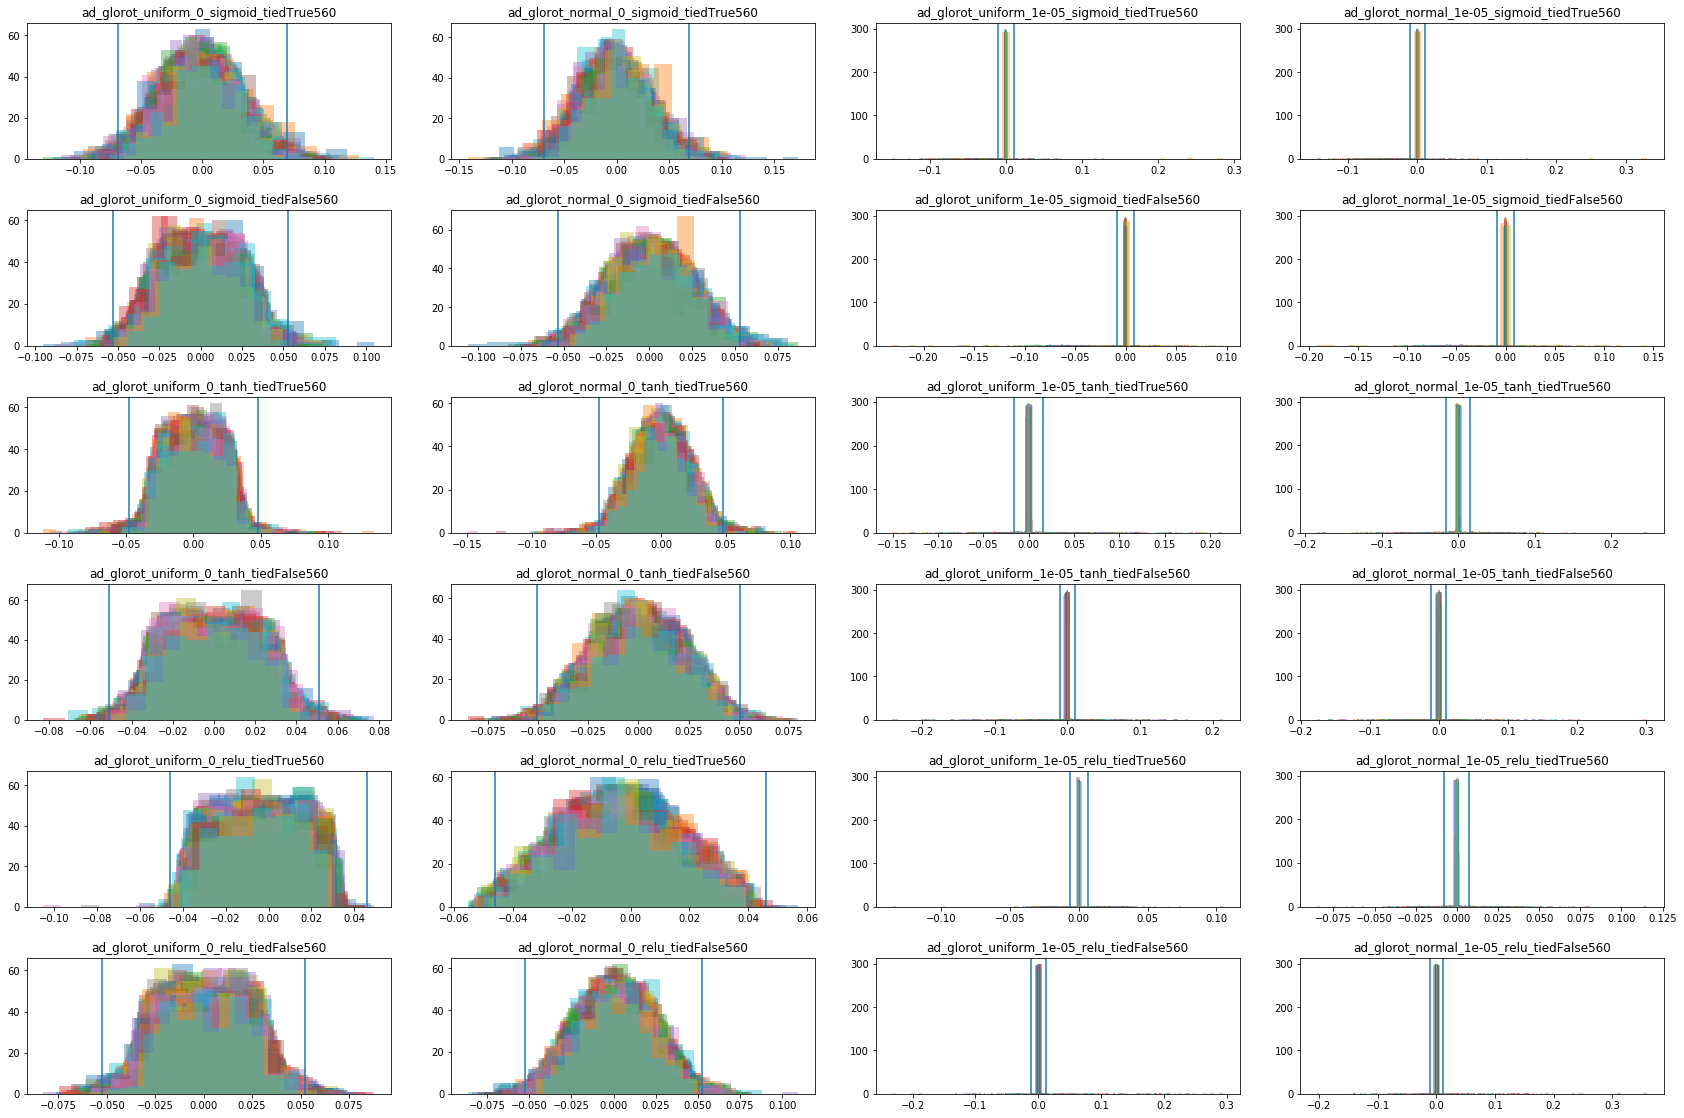

In [521]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict2[name]
                for node in range(0,300):
                    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
                        ax=ax[xi,yi],
                        hist=True,
                        kde=False,
                        rug=False)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*2.5)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*-2.5)
                ax[xi,yi].set(title = name)
                xi = xi+1
        yi=yi+1



In [522]:
fig.savefig('array_distributions_b10.png')

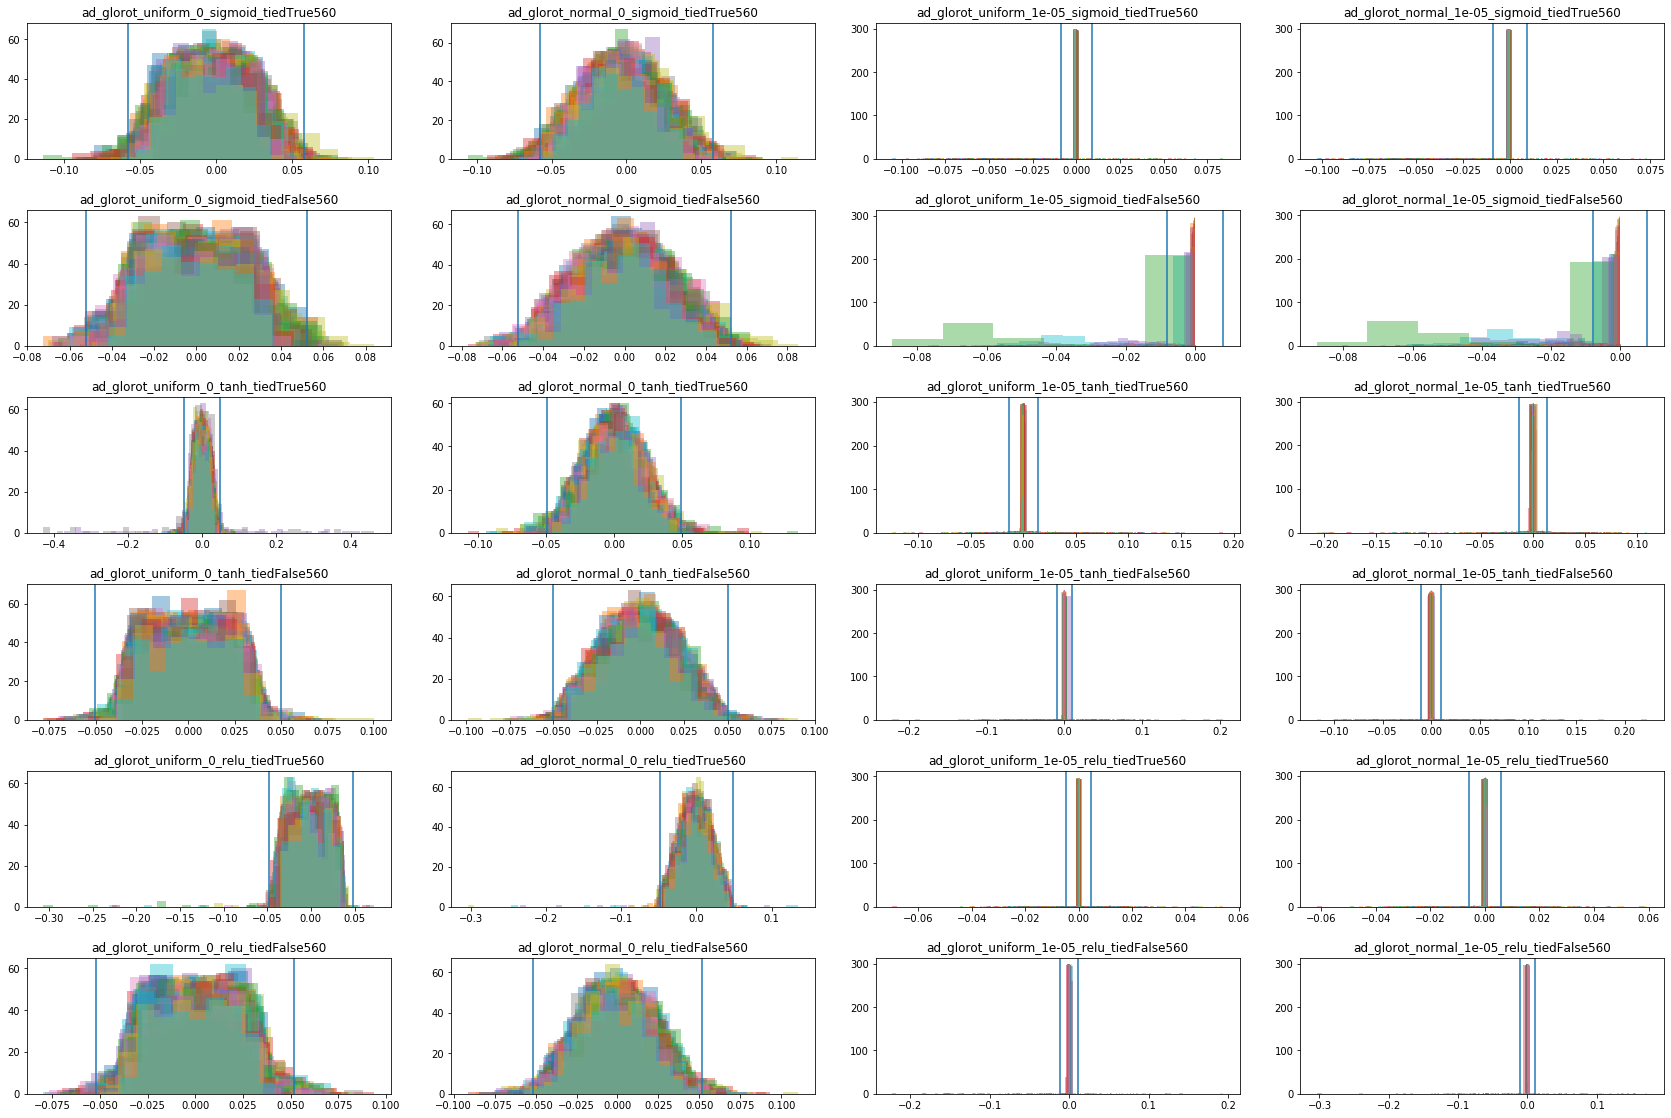

In [523]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict_seq2[name]
                for node in range(0,300):
                    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
                        ax=ax[xi,yi],
                        hist=True,
                        kde=False,
                        rug=False)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*2.5)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*-2.5)
                ax[xi,yi].set(title = name)
                xi = xi+1
        yi=yi+1



In [524]:
fig.savefig('seq_distributions_b10.png')

[Text(0.5, 1, 'ad_glorot_uniform_0_sigmoid_tiedTrue560')]

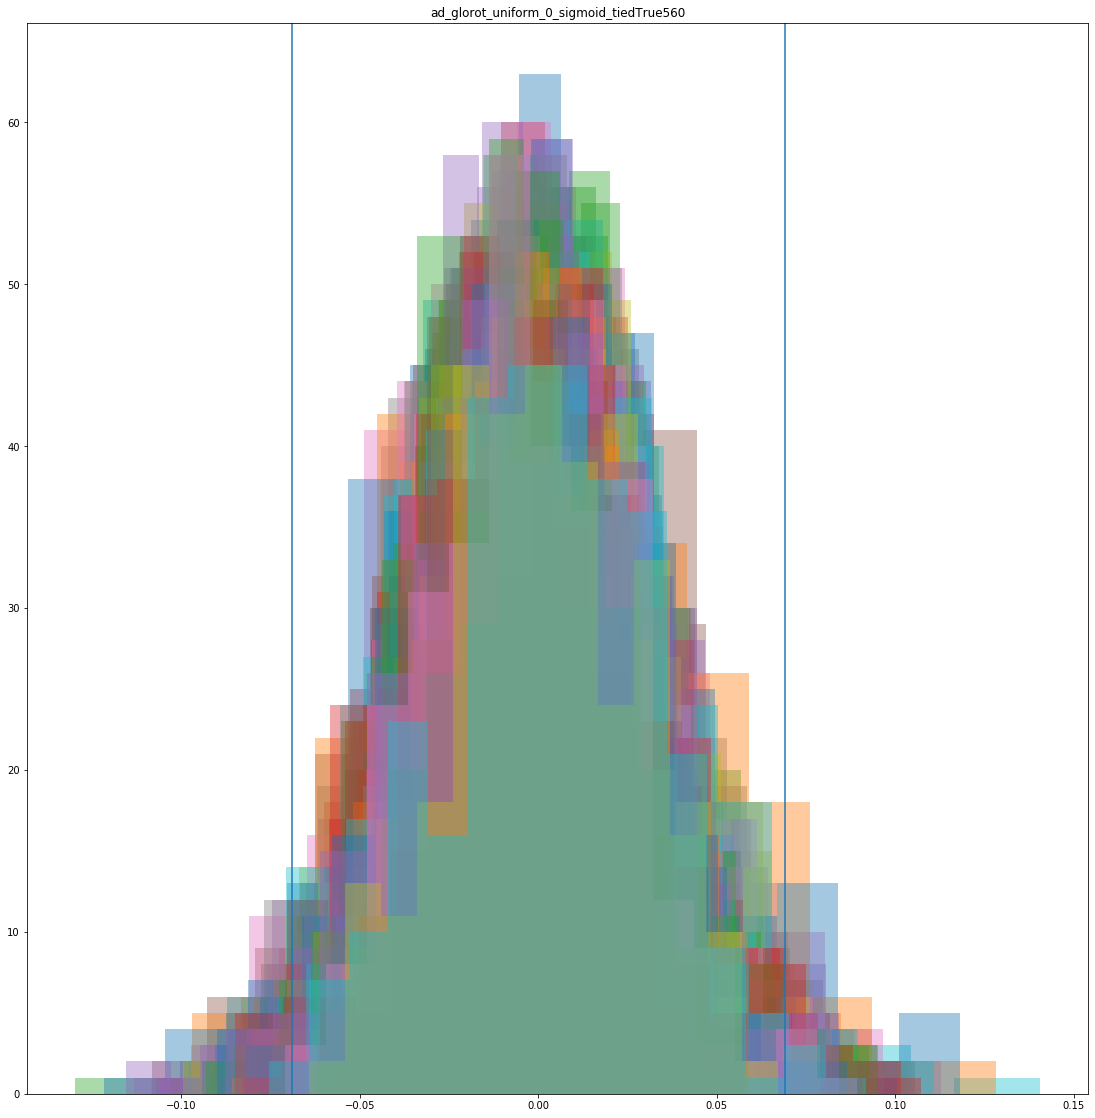

In [255]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*16 ,yd *16))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
name = 'ad_glorot_normal_1e-05_relu_tiedFalse560'
name = 'ad_glorot_uniform_0_sigmoid_tiedTrue560'
model_temp = model_dict2[name]
for node in range(0,300):
    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
    ax=ax,
    hist=True,
    kde=False,
    rug=False)
ax.axvline(x = np.std(model_temp.weights)*2.5)
ax.axvline(x = np.std(model_temp.weights)*-2.5)
ax.set(title = name)
#ax.set_yscale('log')



#### HWG signature sizes

In [258]:
(model_dict2['tf_adage'].weights > np.std(model_dict2['tf_adage'].weights, axis=0)*2.5).shape

(5549, 300)

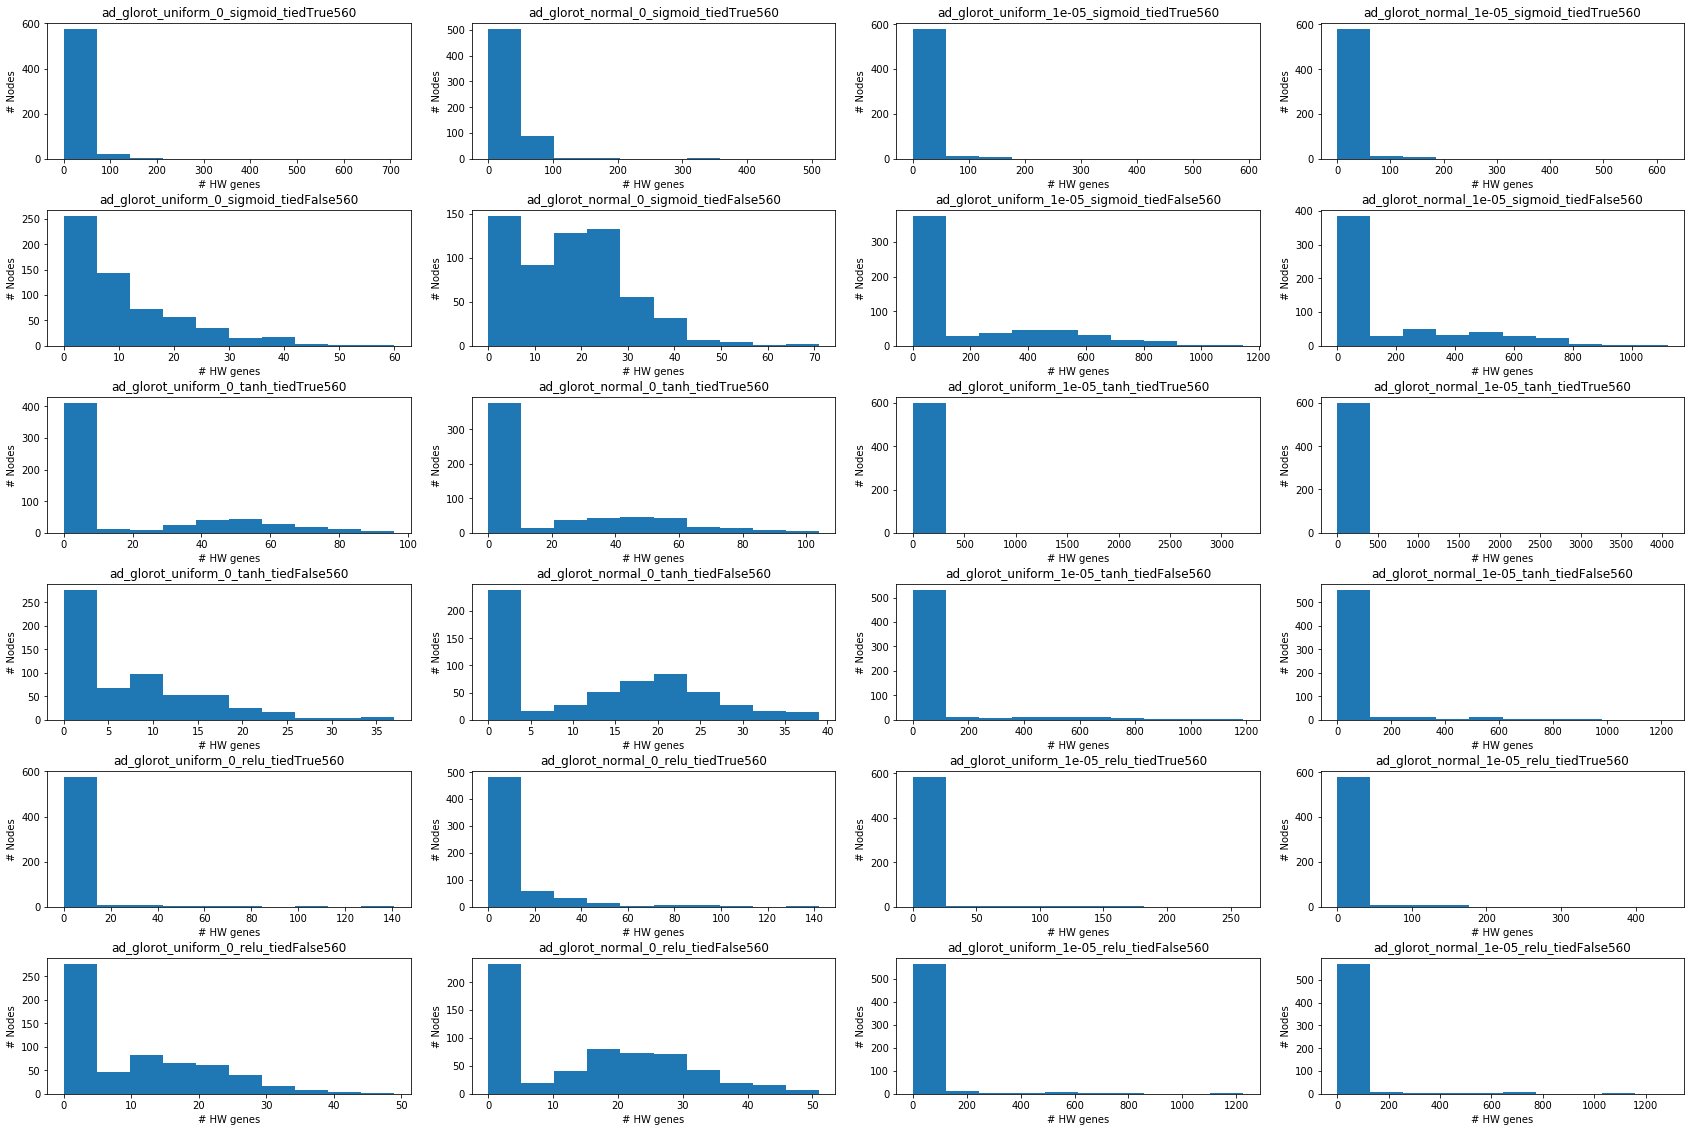

In [257]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict3[name]
                ax[xi,yi].hist(model_temp.hw_genes_all.sum(0))
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                xi = xi+1
        yi=yi+1



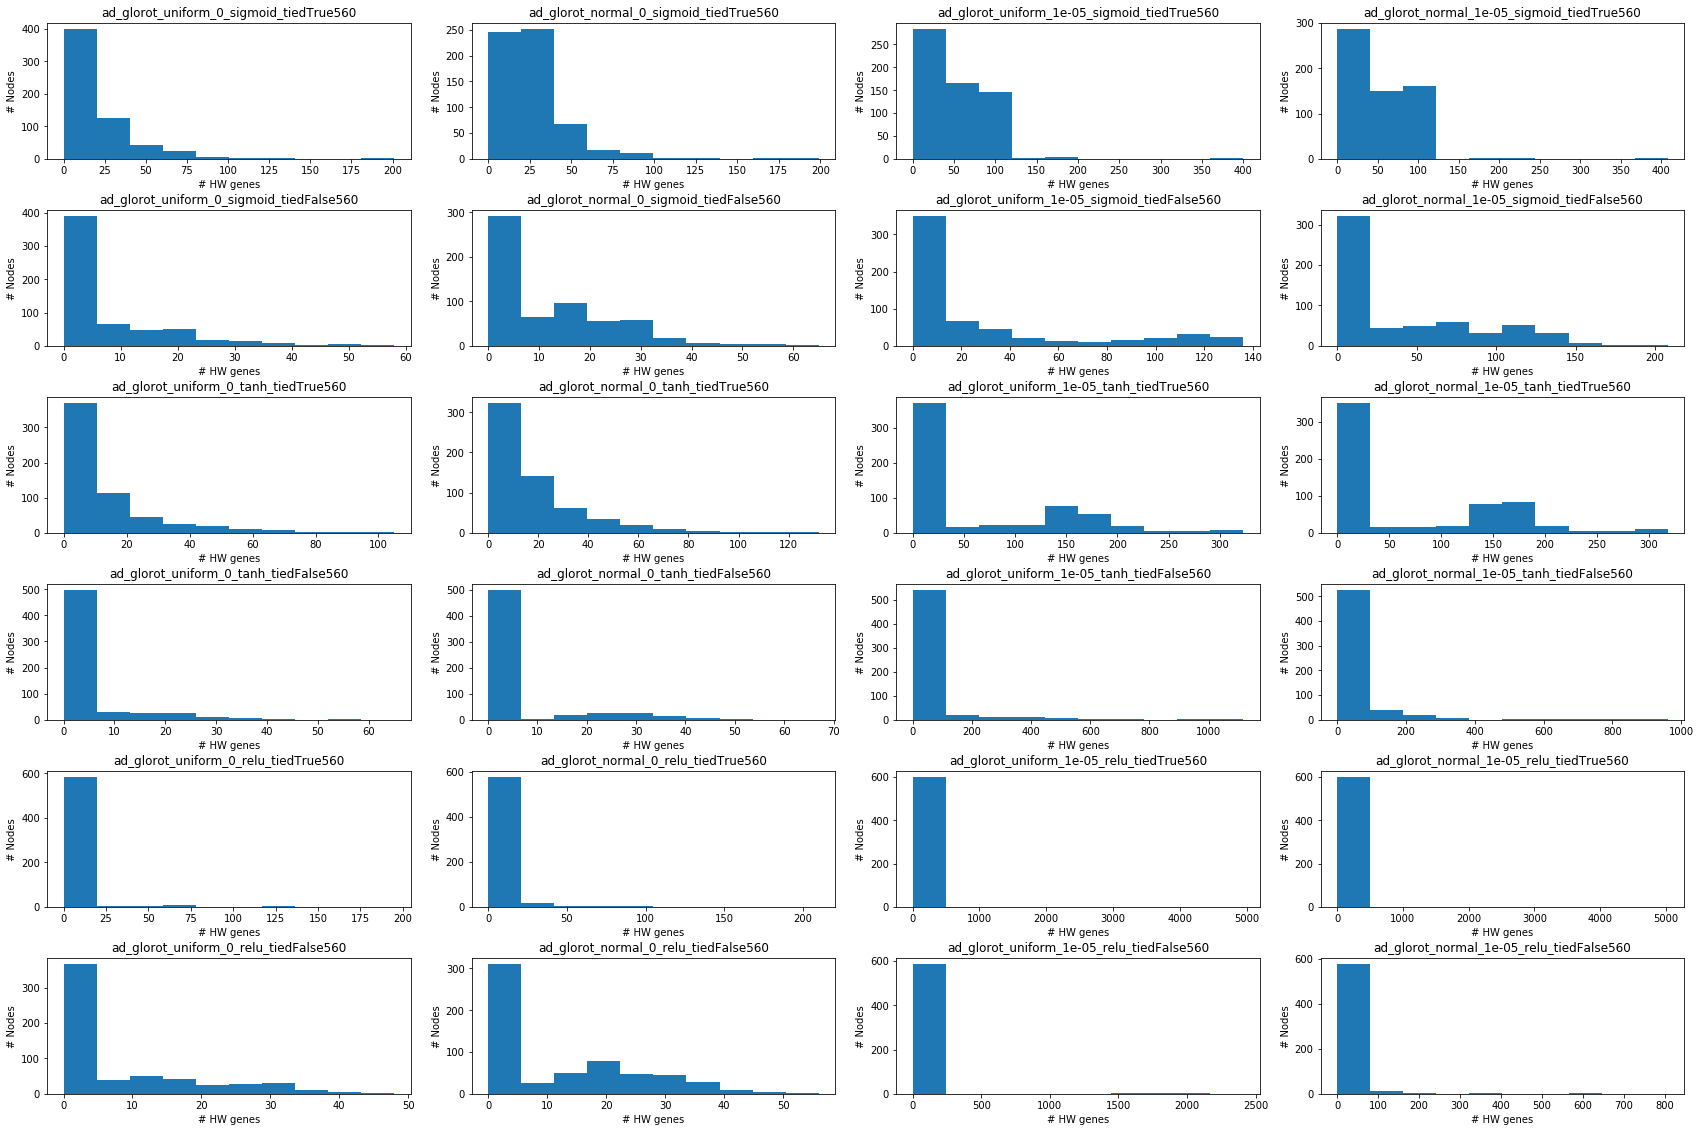

In [259]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict_seq3[name]
                ax[xi,yi].hist(model_temp.hw_genes_all.sum(0))
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                xi = xi+1
        yi=yi+1



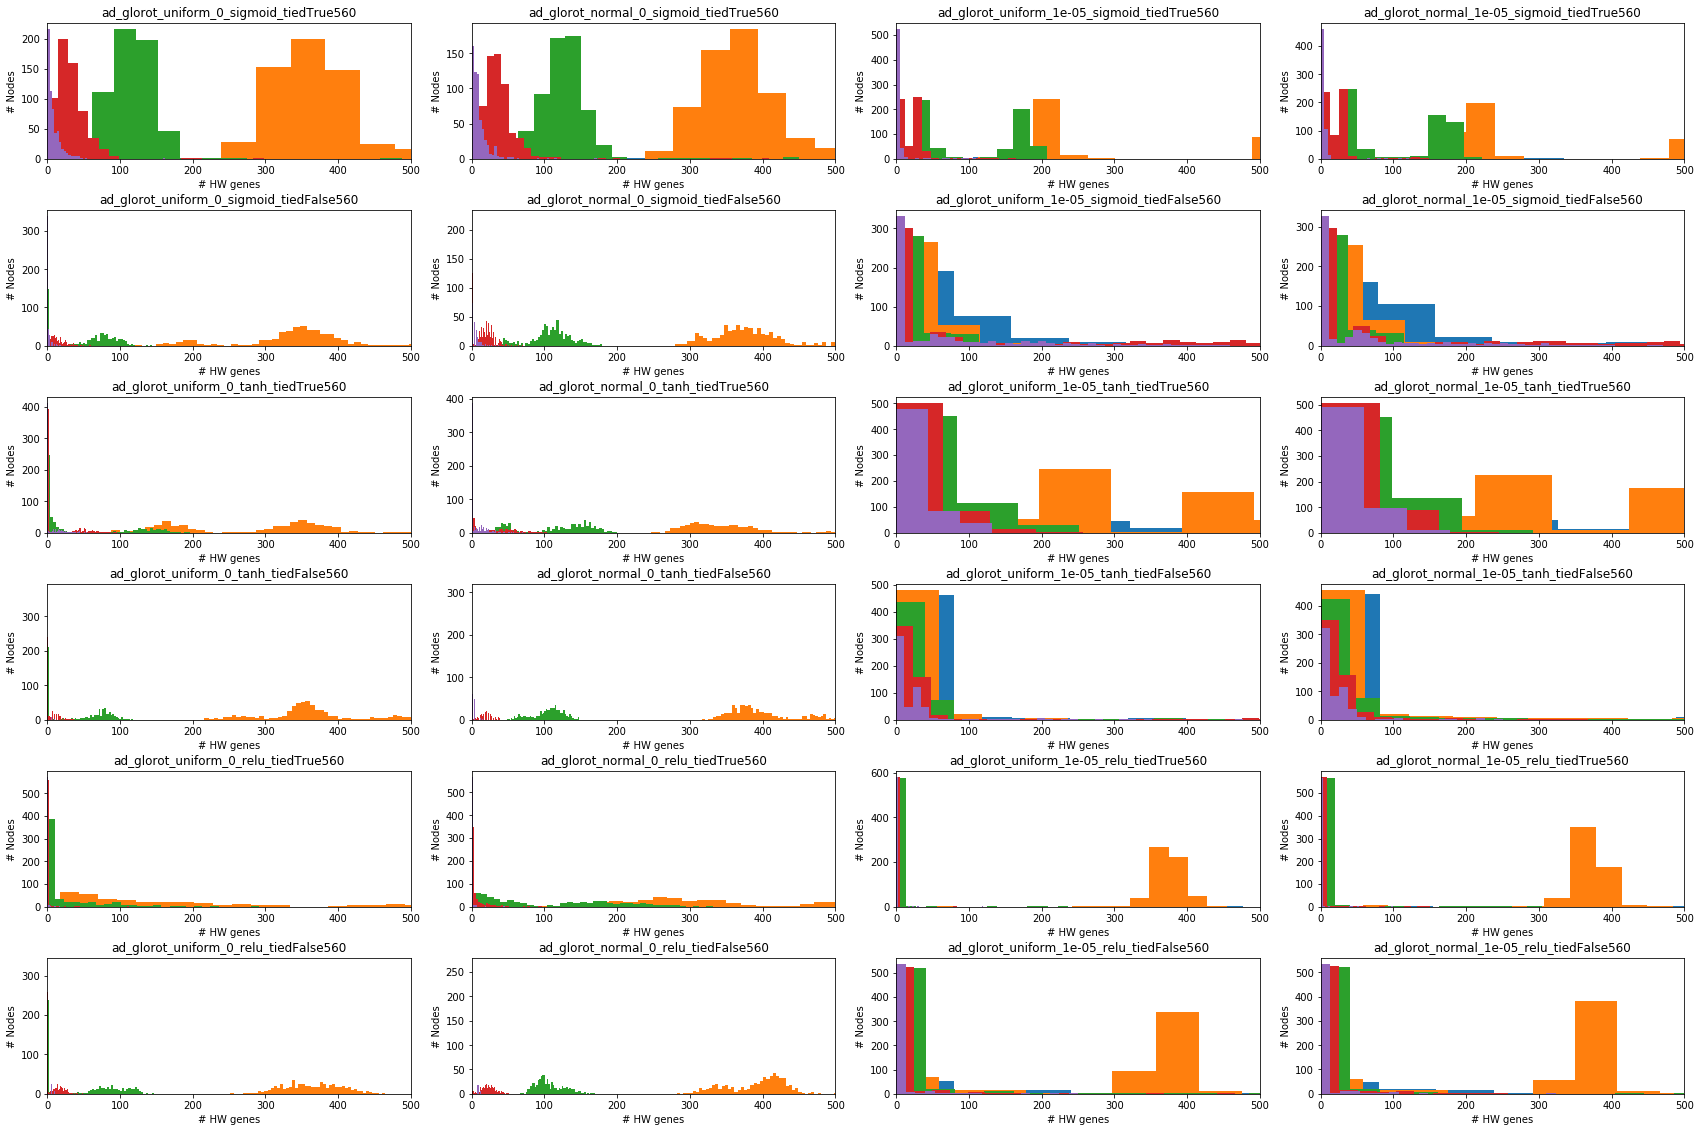

In [426]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict3[name]
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                #ax[xi,yi].set_xscale('log')
                #for c in [1.75,2,2.25,2.5]:
                for c in [1.0,1.5,2.0,2.5,3.0]:
                    model_temp.set_hwg_cutoff(c)
                    ax[xi,yi].hist(model_temp.hw_genes_all.sum(0), bins=50)
                    ax[xi,yi].set_xlim([0,500])

                xi = xi+1
        yi=yi+1

In [427]:
fig.savefig('sig_sizes_by_hw_cutoff_array_xlim500.png')

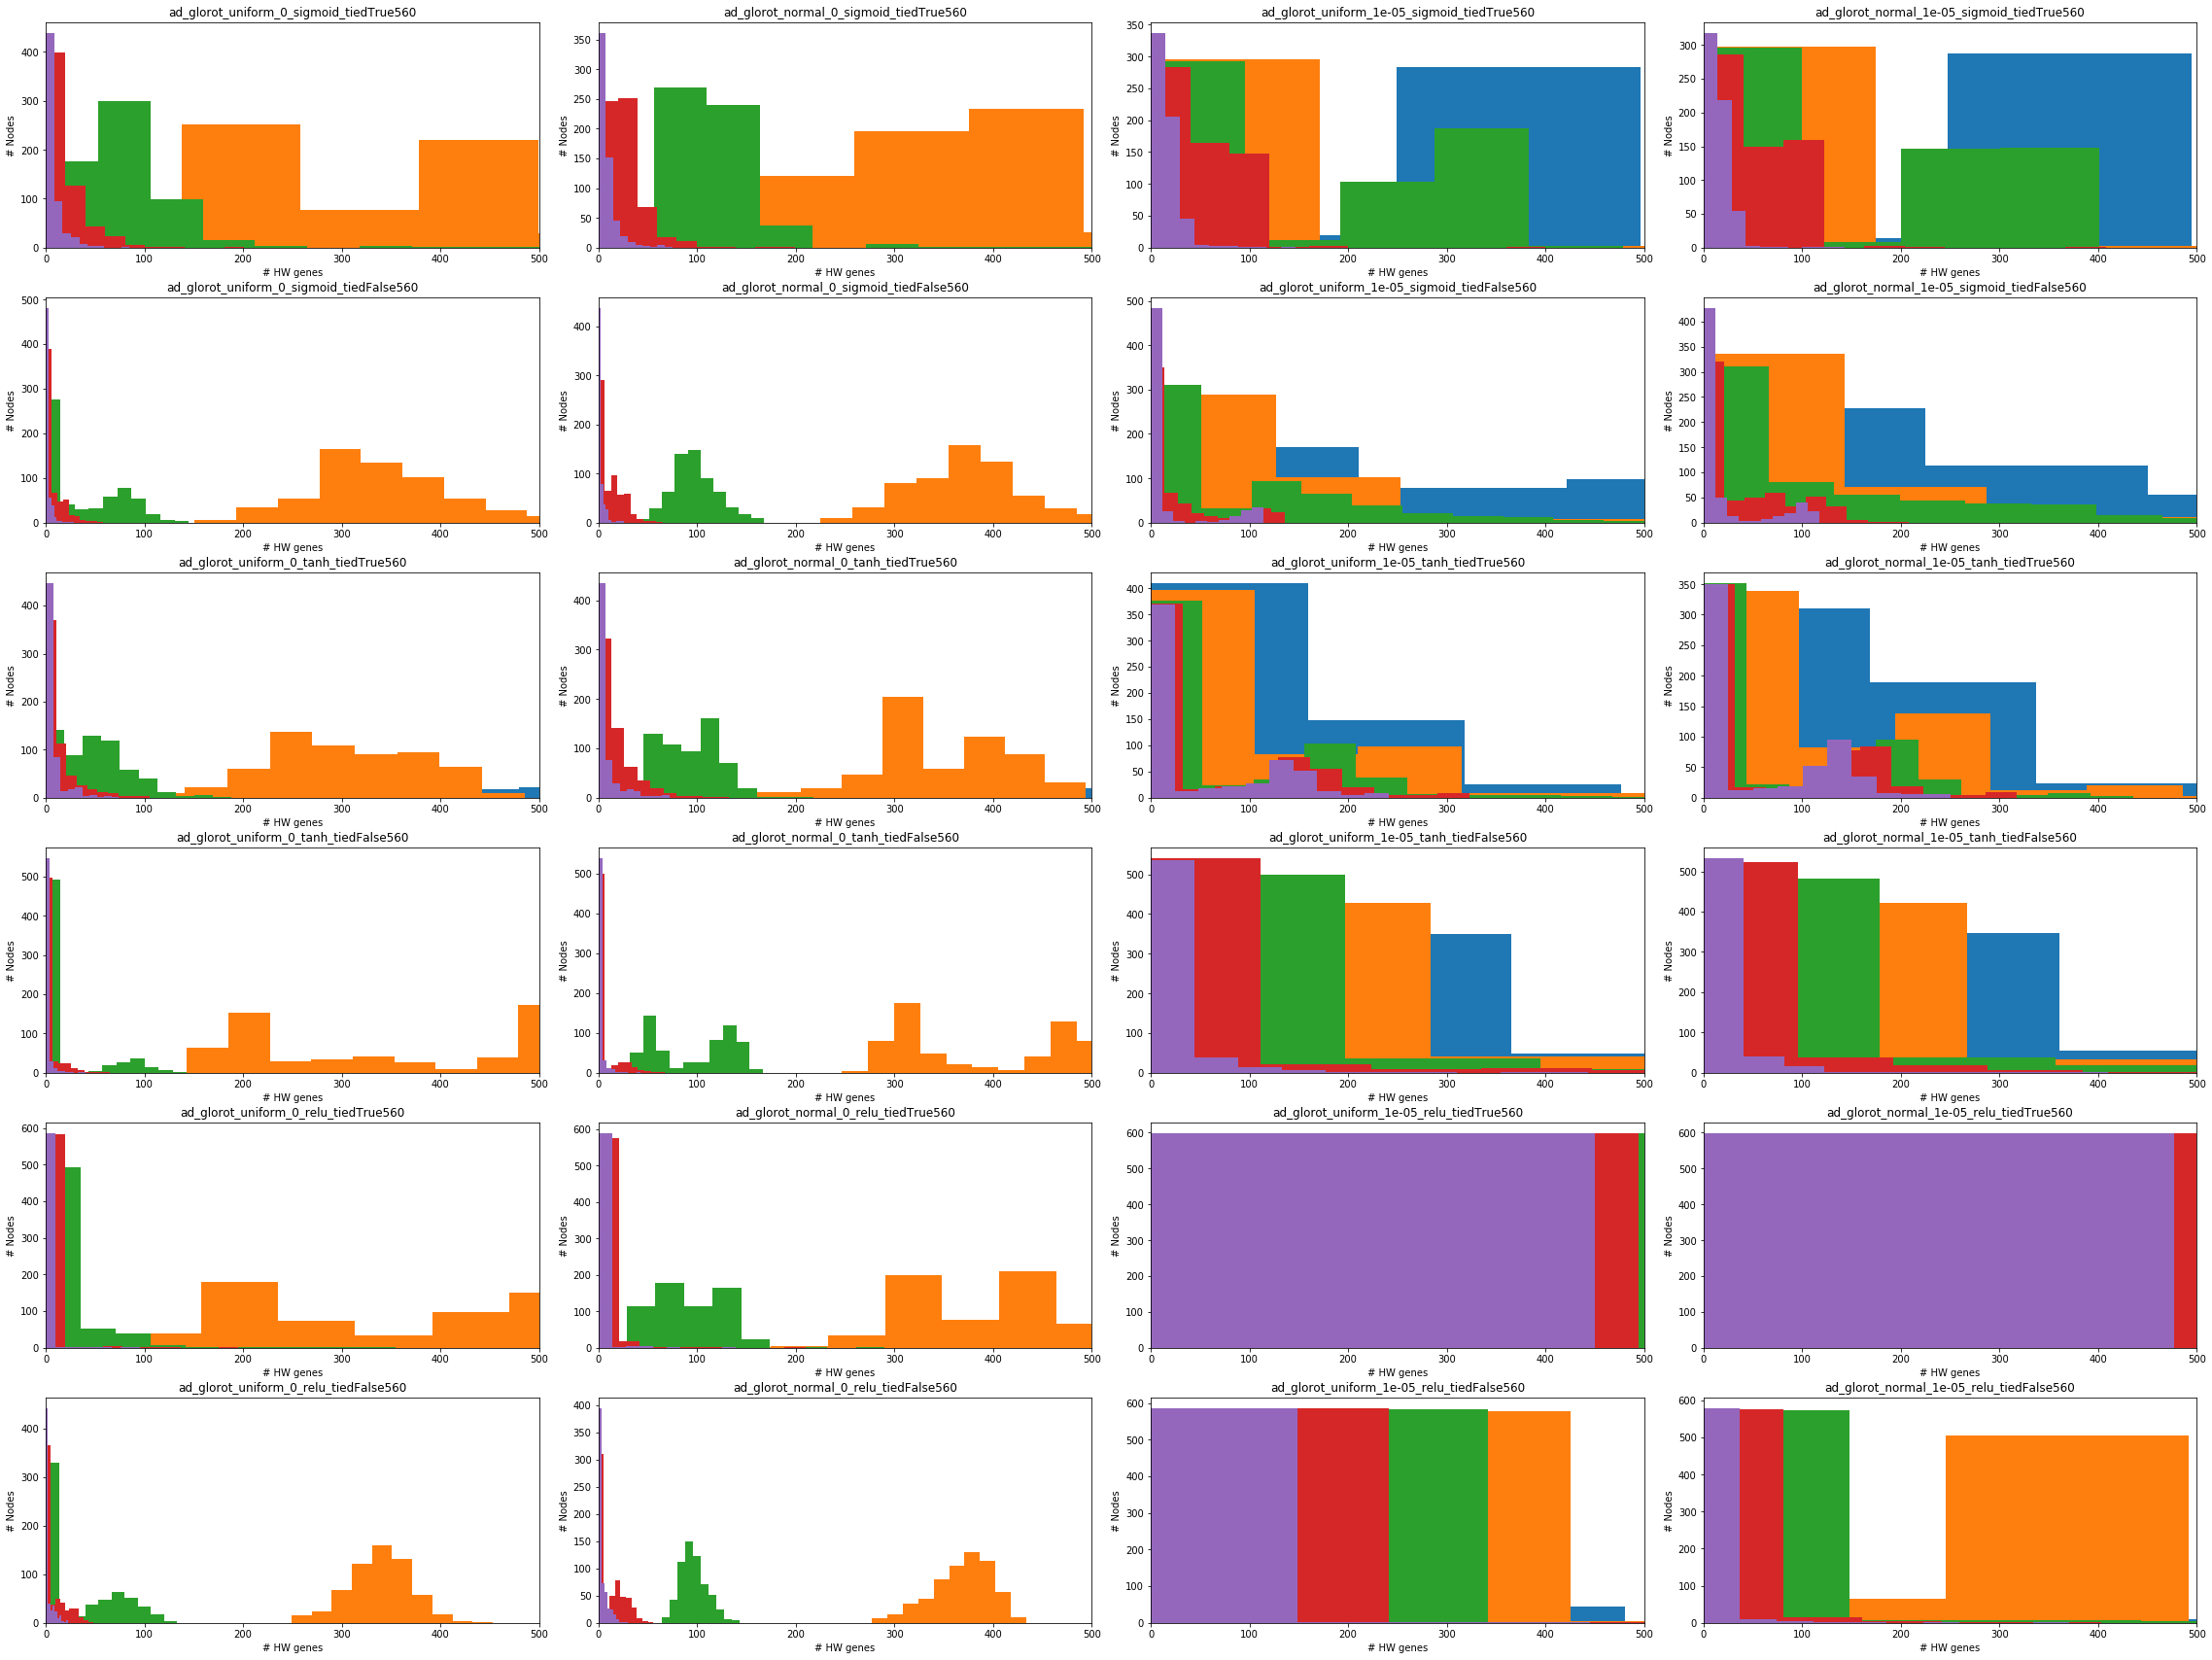

In [428]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(yd*8 ,xd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict_seq3[name]
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                #ax[xi,yi].set_xscale('log')
                #for c in [1.75,2,2.25,2.5]:
                #for c in [3.0,2.5,2.0,1.5,1.0]:
                for c in [1.0,1.5,2.0,2.5,3.0]:
                    model_temp.set_hwg_cutoff(c)
                    ax[xi,yi].hist(model_temp.hw_genes_all.sum(0)) #, bins=50
                    ax[xi,yi].set_xlim([0,500])

                xi = xi+1
        yi=yi+1

In [423]:
fig.savefig('sig_sizes_by_hw_cutoff_seq.png')

[Text(45.125, 0.5, '# Nodes'),
 Text(0.5, 15.0, '# HW genes'),
 Text(0.5, 1, 'tf_adage')]

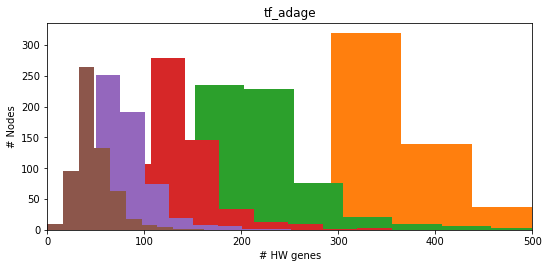

In [300]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*8 ,yd *4))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
name = 'tf_adage'
model_temp = model_dict[name]
for c in [1,1.5,1.75,2,2.25,2.5]:
    model_temp.set_hwg_cutoff(c)
    ax.hist(model_temp.hw_genes_all.sum(0))
    ax.set_xlim([0,500])
ax.set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
#ax.set_yscale('log')



[Text(45.125, 0.5, '# HWGs'),
 Text(0.5, 15.0, 'Cutoff'),
 Text(0.5, 1, 'ad_glorot_normal_0_tanh_tiedTrue560')]

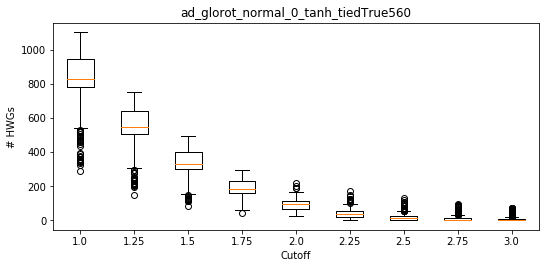

In [409]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*8 ,yd *4))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
name = 'tf_adage'
name = 'ad_glorot_normal_0_tanh_tiedTrue560'
model_temp = model_dict_seq3[name]
hwgs = []
for c in [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0]:
    hwgs_temp = model_temp.set_hwg_cutoff(c)
    hwgs.append(model_temp.hw_genes_all.sum(0))
    
ax.boxplot(hwgs, labels = [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])

ax.set(title = name, xlabel = 'Cutoff', ylabel = '# HWGs')
#ax.set_yscale('log')

[Text(45.125, 0.5, '# KEGG / Node'),
 Text(0.5, 15.0, 'Cutoff'),
 Text(0.5, 1, 'ad_glorot_normal_0_tanh_tiedTrue560')]

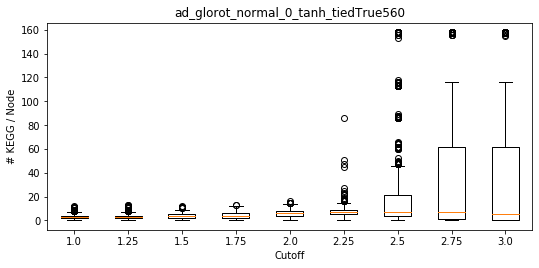

In [410]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*8 ,yd *4))
fig.tight_layout(pad=3.0)



plim=5
name = 'tf_adage'
name = 'ad_glorot_normal_0_tanh_tiedTrue560'
model_temp = model_dict_seq3[name]
hwgs = []
for c in [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0]:
    hwgs_temp = model_temp.set_hwg_cutoff(c)
    model_temp.set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    en_temp = (model_temp.kegg_ps > plim).sum(1)
    hwgs.append(en_temp)
    
ax.boxplot(hwgs, labels = [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])

ax.set(title = name, xlabel = 'Cutoff', ylabel = '# KEGG / Node')
#ax.set_yscale('log')

In [ ]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*8 ,yd *4))
fig.tight_layout(pad=3.0)



plim=5
name = 'tf_adage'
name = 'ad_glorot_normal_0_tanh_tiedTrue560'
model_temp = model_dict_seq3[name]
hwgs = []
for c in [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0]:
    hwgs_temp = model_temp.set_hwg_cutoff(c)
    model_temp.set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    en_temp = (model_temp.kegg_ps > plim).sum(1)
    hwgs.append(en_temp)
    
ax.boxplot(hwgs, labels = [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])

ax.set(title = name, xlabel = 'Cutoff', ylabel = '# KEGG / Node')
#ax.set_yscale('log')

[Text(45.125, 0.5, '# KEGG / Node'),
 Text(0.5, 15.0, 'Cutoff'),
 Text(0.5, 1, 'ad_glorot_uniform_0_sigmoid_tiedTrue560')]

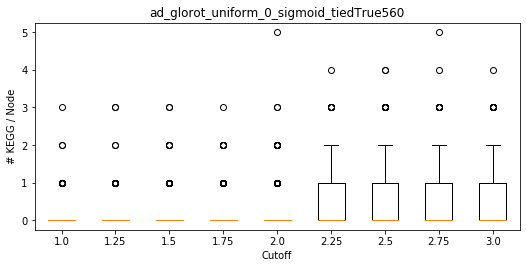

In [355]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*8 ,yd *4))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
#print(name)
plim=10
name = 'ad_glorot_uniform_0_sigmoid_tiedTrue560'
model_temp = model_dict_seq3[name]
hwgs = []
for c in [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0]:
    hwgs_temp = model_temp.set_hwg_cutoff(c)
    model_temp.set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    en_temp = (model_temp.kegg_ps > plim).sum(1)
    hwgs.append(en_temp)
    
ax.boxplot(hwgs, labels = [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])

ax.set(title = name, xlabel = 'Cutoff', ylabel = '# KEGG / Node')
#ax.set_yscale('log')

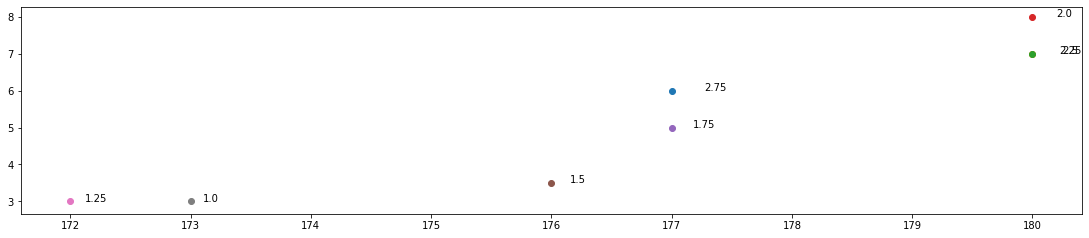

In [414]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*16 ,yd *4))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
#print(name)
plim=5
name = 'ad_glorot_uniform_0_sigmoid_tiedTrue560'
name = 'ad_glorot_uniform_0_tanh_tiedTrue560'
model_temp = model_dict_seq3[name]
hwgs = []
for c in [2.75,2.5,2.25,2.0, 1.75,1.5, 1.25, 1.0]:
    hwgs_temp = model_temp.set_hwg_cutoff(c)
    model_temp.set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    en_temp = (model_temp.kegg_ps > plim).sum(1)
    hwgs.append(en_temp)
    kegg_per_med = (model_temp.kegg_ps > plim).sum(1).median()
    all_kegg = ((model_temp.kegg_ps > plim).sum(0) > 0).sum()
    ax.scatter(x = all_kegg , y = kegg_per_med)
    ax.text(x = all_kegg+(c/10), y = kegg_per_med,s = str(c))
               

               #ax.hist(hwgs, label = [2.75,2.5,2.25,2.0])
#ax.legend(prop={'size': 10})
    
#ax.boxplot(hwgs, labels = [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])

#ax.set(title = name, xlabel = 'Cutoff', ylabel = '# KEGG / Node')
#ax.set_yscale('log')

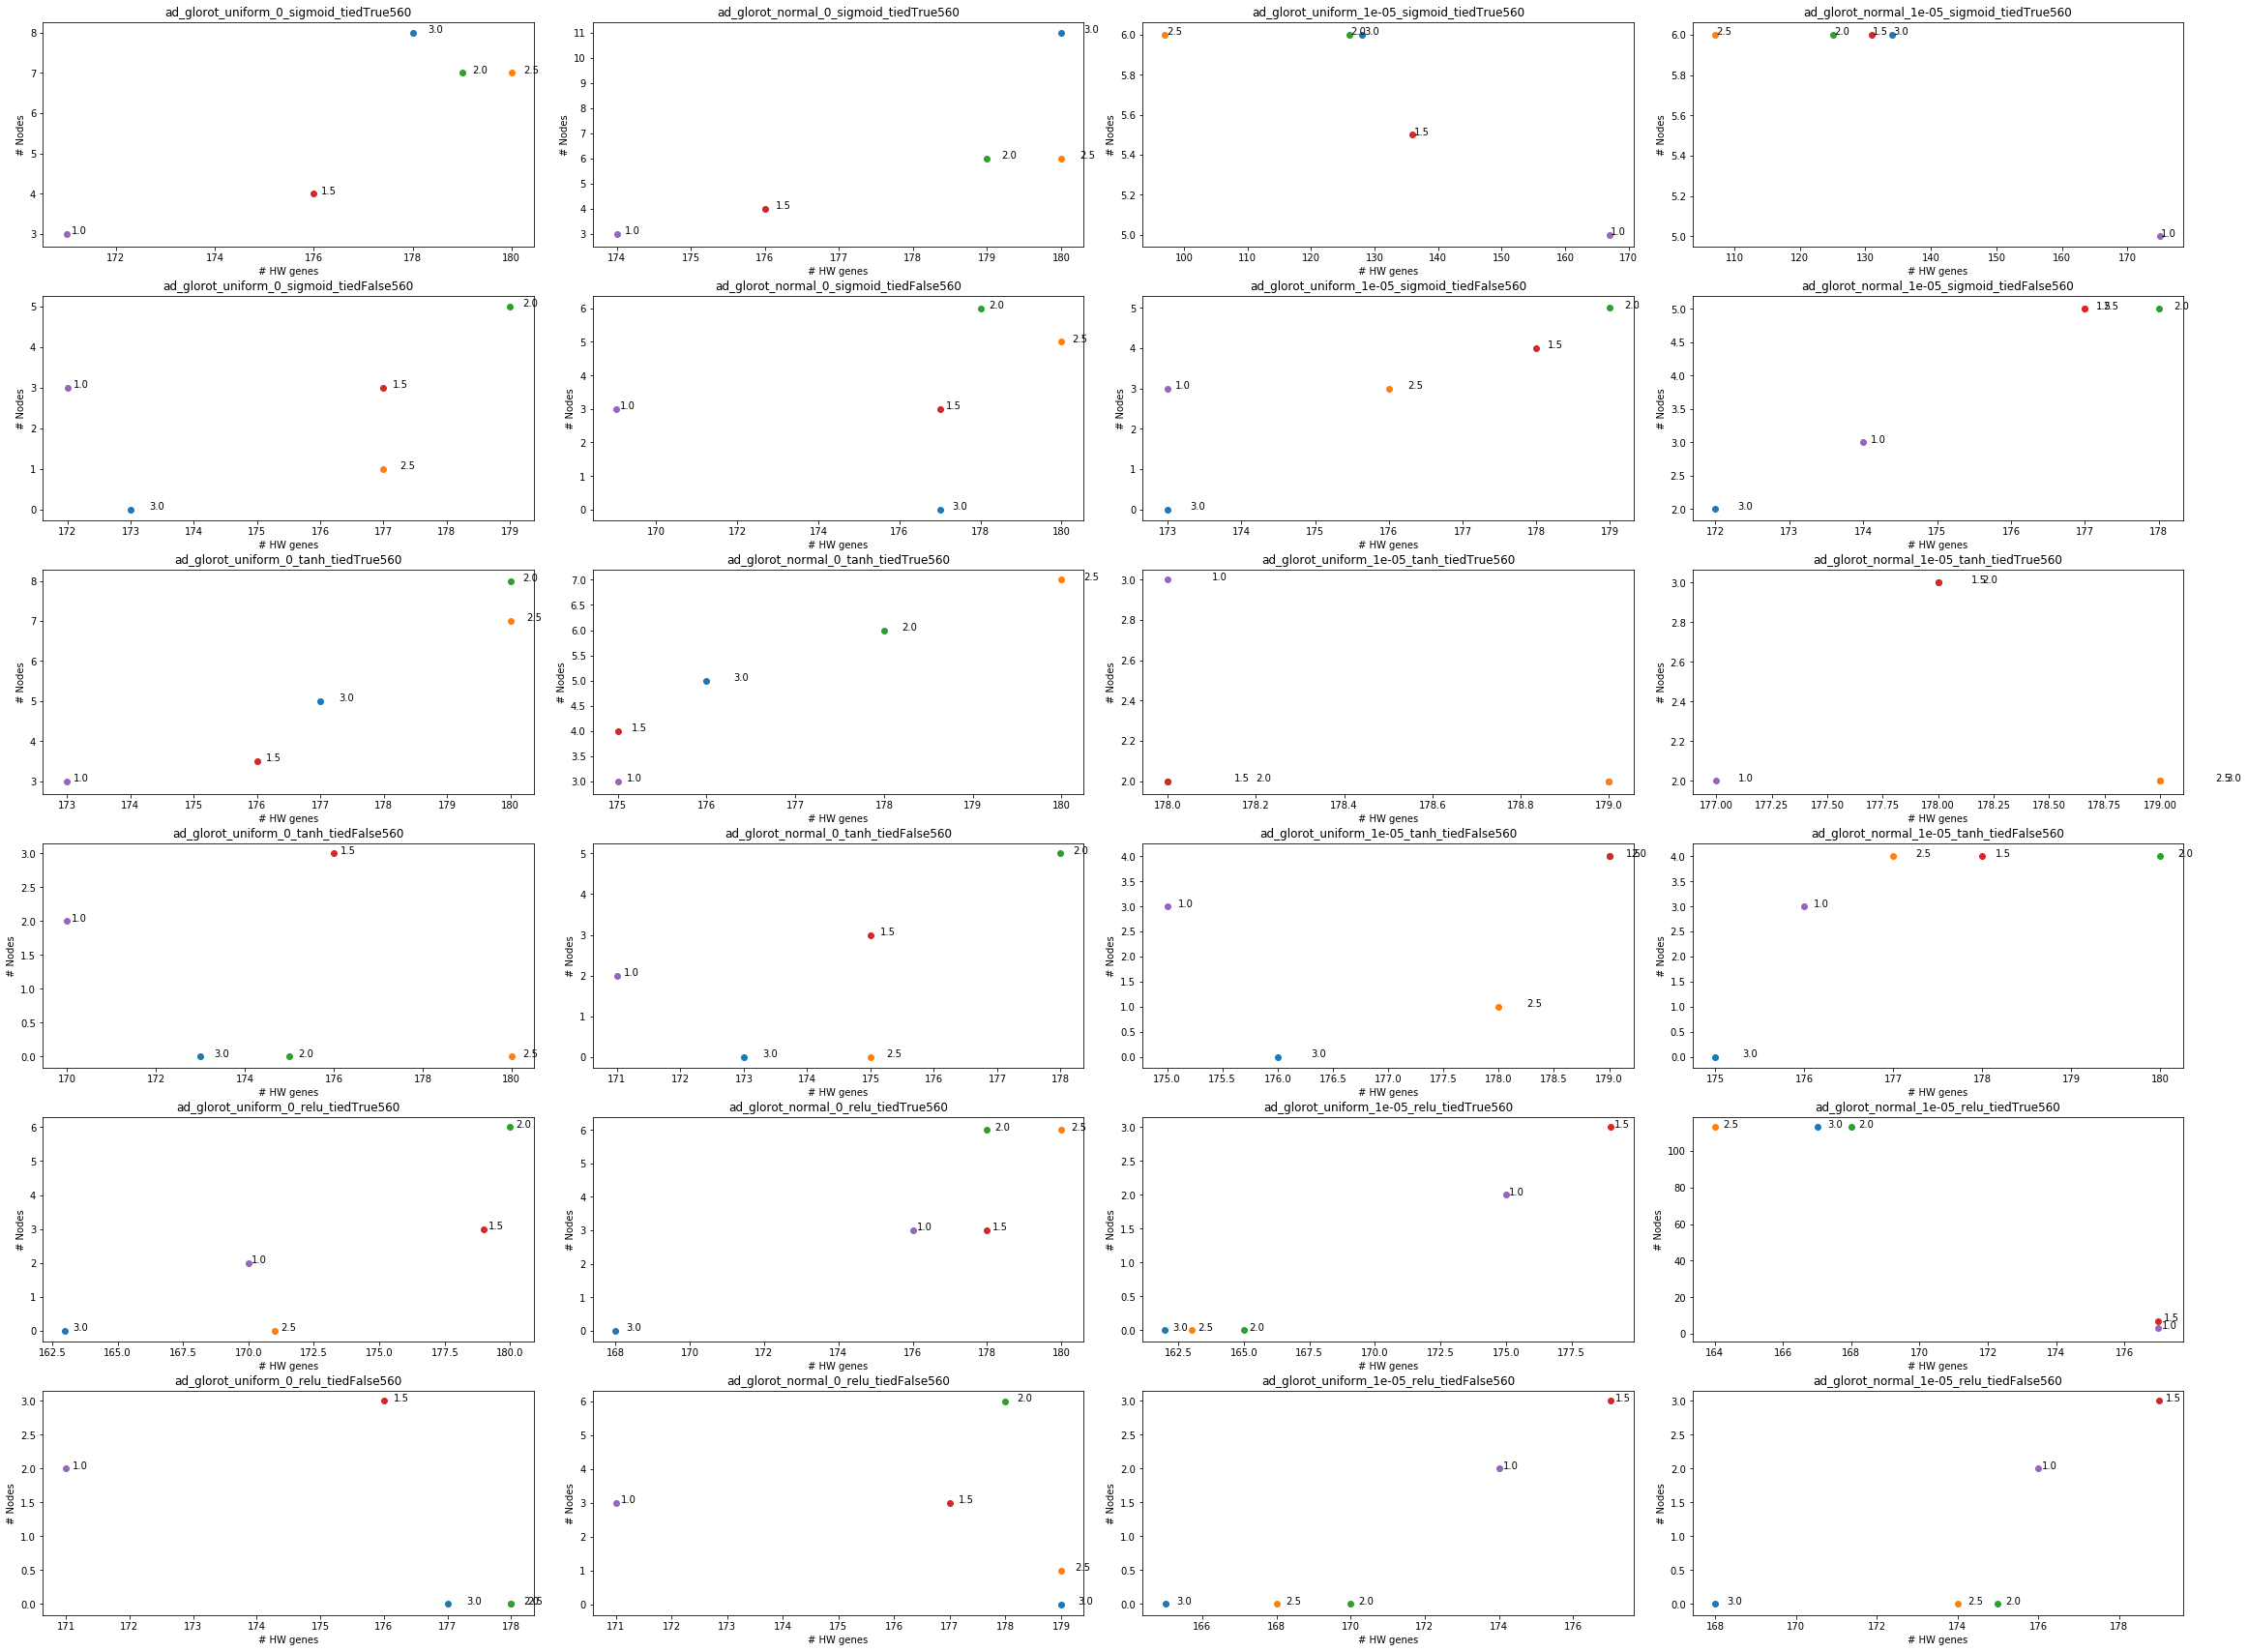

In [415]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(yd*8 ,xd *4))
fig.tight_layout(pad=3.0)
plim = 5
xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict_seq3[name]
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                #ax[xi,yi].set_xscale('log')
                #for c in [1.75,2,2.25,2.5]:
                hwgs = []
                for c in [3.0,2.5,2.0,1.5,1.0]:
                    hwgs_temp = model_temp.set_hwg_cutoff(c)
                    model_temp.set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
                    en_temp = (model_temp.kegg_ps > plim).sum(1)
                    hwgs.append(en_temp)
                    kegg_per_med = (model_temp.kegg_ps > plim).sum(1).median()
                    all_kegg = ((model_temp.kegg_ps > plim).sum(0) > 0).sum()
                    ax[xi,yi].scatter(x = all_kegg , y = kegg_per_med)
                    ax[xi,yi].text(x = all_kegg+(c/10), y = kegg_per_med,s = str(c))

                xi = xi+1
        yi=yi+1

In [416]:
fig.savefig('kegg_en_by_hw_cutoff_seq.png')

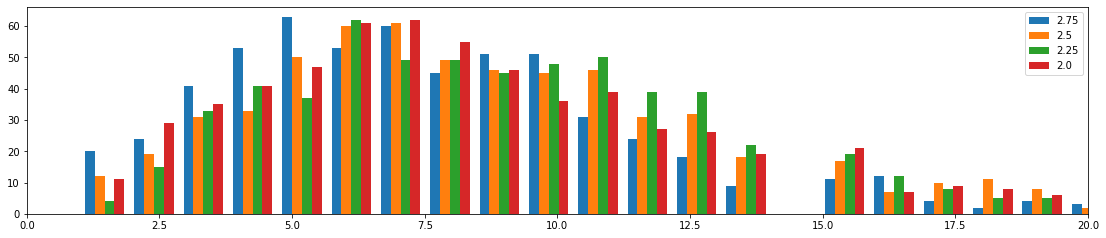

In [342]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*16 ,yd *4))
fig.tight_layout(pad=3.0)
ax.hist(hwgs,bins = 100, label = [2.75,2.5,2.25,2.0])
ax.set_xlim([0,20])
ax.legend(prop={'size': 10})

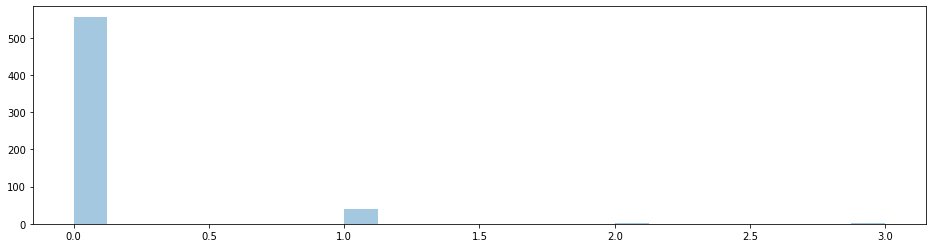

In [385]:
fig, ax = plt.subplots(xd, yd,figsize=(xd*16 ,yd *4))
sns.distplot(hwgs[0], ax=ax, kde=False)

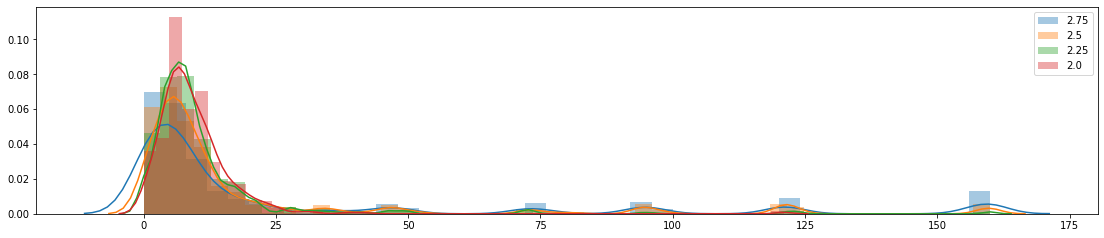

In [400]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*16 ,yd *4))
fig.tight_layout(pad=3.0)
for n in range(4):
    sns.distplot(hwgs[n], label = [2.75,2.5,2.25,2.0][n], #[model_temp.weights[node] > 0],
    ax=ax,
    hist=True,
    kde=True
)
ax.legend()
#ax.axvline(x = np.std(model_temp.weights)*2.5)
#ax.axvline(x = np.std(model_temp.weights)*-2.5)
#ax.set(title = name)

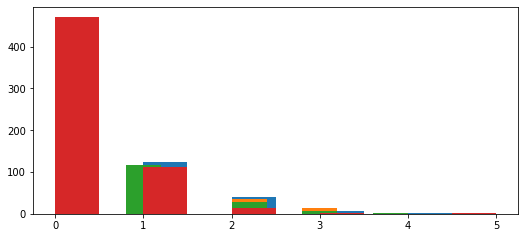

In [321]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*8 ,yd *4))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
#print(name)
plim=10
name = 'ad_glorot_uniform_0_sigmoid_tiedTrue560'
model_temp = model_dict_seq3[name]
hwgs = []
for c in [2.75,2.5,2.25,2.0]:
    hwgs_temp = model_temp.set_hwg_cutoff(c)
    model_temp.set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    ax.hist((model_temp.kegg_ps > plim).sum(1))
    
#ax.boxplot(hwgs, labels = [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])

#ax.set(title = name, xlabel = 'Cutoff', ylabel = '# KEGG / Node')
#ax.set_yscale('log')

In [333]:
(model_dict['tf_adage'].kegg_ps > 10).sum(1)[(model_dict['tf_adage'].kegg_ps > 10).sum(1) > 0]

TypeError: '>' not supported between instances of 'list' and 'int'

In [305]:

model_dict['tf_adage'].set_hwg_cutoff(2.5)
model_dict['tf_adage'].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt')
((model_dict['tf_adage'].kegg_ps > 10).sum(1) > 0).sum()

334

#### Enrichments

In [ ]:
for m in model_dict:
    model_dict[m].set_hwg_cutoff(2.5)
    #model_dict[m].set_kegg('node_interpretation/operons_format.txt')
    model_dict[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    #model_dict[m].set_go('node_interpretation/regulons_format.txt')
  

##### Summary Fig

In [ ]:
plim = 30

fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].go_ps > plim).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plim).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(10):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict[name]
                    x = ((model_temp.go_ps > plim).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plim).sum(1) > 0).sum()
                    ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    ax.set(title = m, xlabel = '# Regulons', ylabel = '# Nodes')

                    #xi = xi+1
                ec='red'
            mi = mi+1
        s=500
    c = 'grey'

##### Details

In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for i in inits:
    for l in L1_norm:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].hist((model_temp.kegg_ps > 10).sum(0))
                ax[xi,yi].set(title = name, xlabel = '# Nodes per Pathway', ylabel = '# Pathways')
                xi = xi+1
        yi=yi+1





In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for i in inits:
    for l in L1_norm:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].hist((model_temp.kegg_ps > 10).sum(1))
                ax[xi,yi].set(title = name, xlabel = '# Pathways in Node', ylabel = '# Nodes')
                xi = xi+1
        yi=yi+1


### Write out HWG lists

In [276]:
for m in model_dict_seq3:
    model_dict_seq3[m].set_hwg_cutoff(2.0)
    #model_dict_seq[m].set_op('node_interpretation/operons_format.txt')
    #print('op done')
    model_dict_seq3[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    #print('kegg done')
    model_dict_seq3[m].set_go('node_interpretation/manual_GO_BP_terms.txt') 
    #print('go done')
    model_dict_seq3[m].set_reg('node_interpretation/regulons_format.txt')
    #print('reg done')
    print(m)
print('dict seq done') 

tf_adage
ad_glorot_uniform_0_sigmoid_tiedTrue560
ad_glorot_uniform_0_sigmoid_tiedTrue561
ad_glorot_uniform_0_sigmoid_tiedTrue562
ad_glorot_uniform_0_sigmoid_tiedFalse560
ad_glorot_uniform_0_sigmoid_tiedFalse561
ad_glorot_uniform_0_sigmoid_tiedFalse562
ad_glorot_uniform_0_tanh_tiedTrue560
ad_glorot_uniform_0_tanh_tiedTrue561
ad_glorot_uniform_0_tanh_tiedTrue562
ad_glorot_uniform_0_tanh_tiedFalse560
ad_glorot_uniform_0_tanh_tiedFalse561
ad_glorot_uniform_0_tanh_tiedFalse562
ad_glorot_uniform_0_relu_tiedTrue560
ad_glorot_uniform_0_relu_tiedTrue561
ad_glorot_uniform_0_relu_tiedTrue562
ad_glorot_uniform_0_relu_tiedFalse560
ad_glorot_uniform_0_relu_tiedFalse561
ad_glorot_uniform_0_relu_tiedFalse562
ad_glorot_uniform_1e-05_sigmoid_tiedTrue560
ad_glorot_uniform_1e-05_sigmoid_tiedTrue561
ad_glorot_uniform_1e-05_sigmoid_tiedTrue562
ad_glorot_uniform_1e-05_sigmoid_tiedFalse560
ad_glorot_uniform_1e-05_sigmoid_tiedFalse561
ad_glorot_uniform_1e-05_sigmoid_tiedFalse562
ad_glorot_uniform_1e-05_tanh_ti

In [196]:
for m in model_dict:
    model_dict[m].set_hwg_cutoff(2.5)
    model_dict[m].set_op('node_interpretation/operons_format.txt')

print('dict done') 

for m in model_dict_seq:
    model_dict_seq[m].set_hwg_cutoff(2.5)
    model_dict_seq[m].set_op('node_interpretation/operons_format.txt')

print('dict seq done') 

for m in model_dict2:
    model_dict2[m].set_hwg_cutoff(2.5)
    model_dict2[m].set_op('node_interpretation/operons_format.txt')

print('dict2 done')  

for m in model_dict_seq2:
    model_dict_seq2[m].set_hwg_cutoff(2.5)
    model_dict_seq2[m].set_op('node_interpretation/operons_format.txt')

print('dict seq2 done') 

dict done
dict seq done


KeyboardInterrupt: 

In [534]:
for m in model_dict3:
    model_dict3[m].set_hwg_cutoff(2.5)
    model_dict3[m].set_op('node_interpretation/operons_format.txt')

print('dict2 done')  

for m in model_dict_seq3:
    model_dict_seq3[m].set_hwg_cutoff(2.5)
    model_dict_seq3[m].set_op('node_interpretation/operons_format.txt')

print('dict seq2 done') 

dict2 done
dict seq2 done


In [142]:
for m in model_dict:
    model_dict[m].set_hwg_cutoff(2.5)
    model_dict[m].set_op('node_interpretation/operons_format.txt')
    print('op done')
    model_dict[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    print('kegg done')
    model_dict[m].set_go('node_interpretation/manual_GO_BP_terms.txt') 
    print('go done')
    model_dict[m].set_reg('node_interpretation/regulons_format.txt')
    print('reg done')
print('dict done') 

for m in model_dict_seq:
    model_dict_seq[m].set_hwg_cutoff(2.5)
    model_dict_seq[m].set_op('node_interpretation/operons_format.txt')
    print('op done')
    model_dict_seq[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    print('kegg done')
    model_dict_seq[m].set_go('node_interpretation/manual_GO_BP_terms.txt') 
    print('go done')
    model_dict_seq[m].set_reg('node_interpretation/regulons_format.txt')
    print('reg done')
print('dict seq done') 

for m in model_dict2:
    model_dict2[m].set_hwg_cutoff(2.5)
    model_dict2[m].set_op('node_interpretation/operons_format.txt')
    print('op done')
    model_dict2[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    print('kegg done')
    model_dict2[m].set_go('node_interpretation/manual_GO_BP_terms.txt') 
    print('go done')
    model_dict2[m].set_reg('node_interpretation/regulons_format.txt')
    print('reg done')
print('dict2 done')  

for m in model_dict_seq2:
    model_dict_seq2[m].set_hwg_cutoff(2.5)
    model_dict_seq2[m].set_op('node_interpretation/operons_format.txt')
    print('op done')
    model_dict_seq2[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    print('kegg done')
    model_dict_seq2[m].set_go('node_interpretation/manual_GO_BP_terms.txt') 
    print('go done')
    model_dict_seq2[m].set_reg('node_interpretation/regulons_format.txt')
    print('reg done')
print('dict seq2 done') 

op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go

NameError: name 'model_dict_seq' is not defined

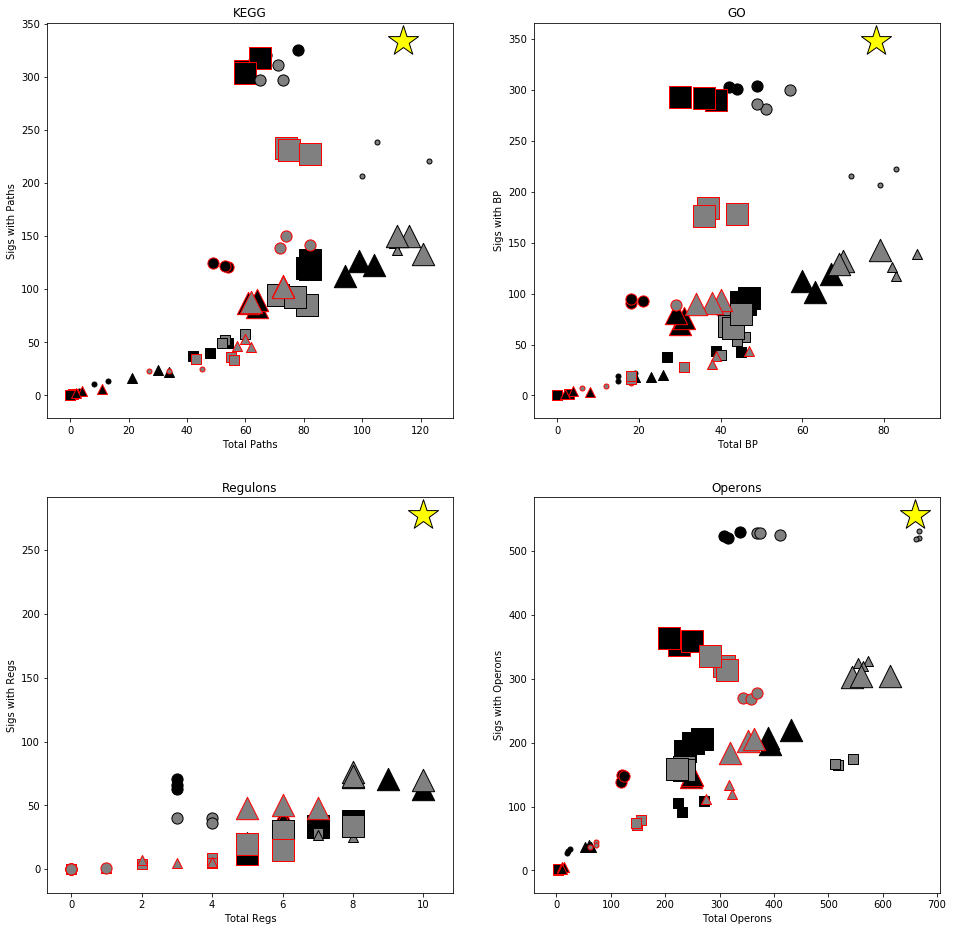

In [303]:
5plimk=10
plimg=10
plimr=10
plimo=10
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(3):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                   
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                    y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)

                ec='red'
            mi = mi+1
        s=500
    c = 'grey'



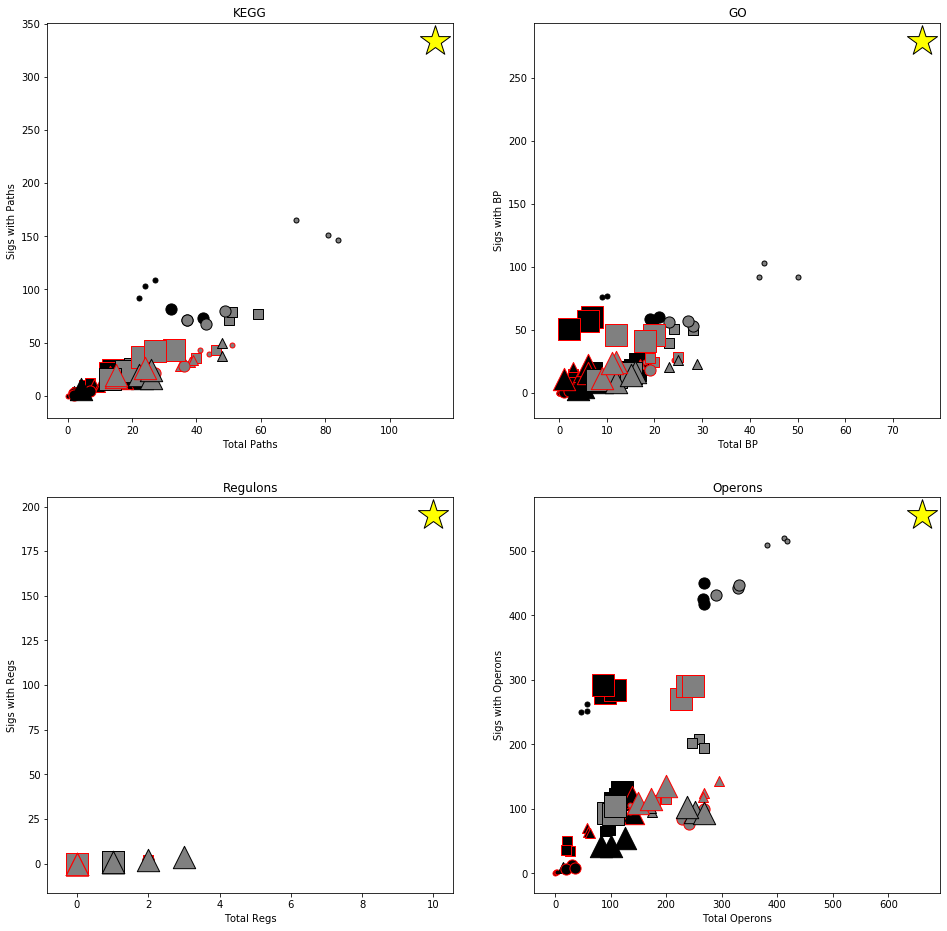

In [207]:
plimk=10
plimg=10
plimr=10
plimo=10
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(3):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict_seq[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                    y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)

                ec='red'
            mi = mi+1
        s=500
    c = 'grey'



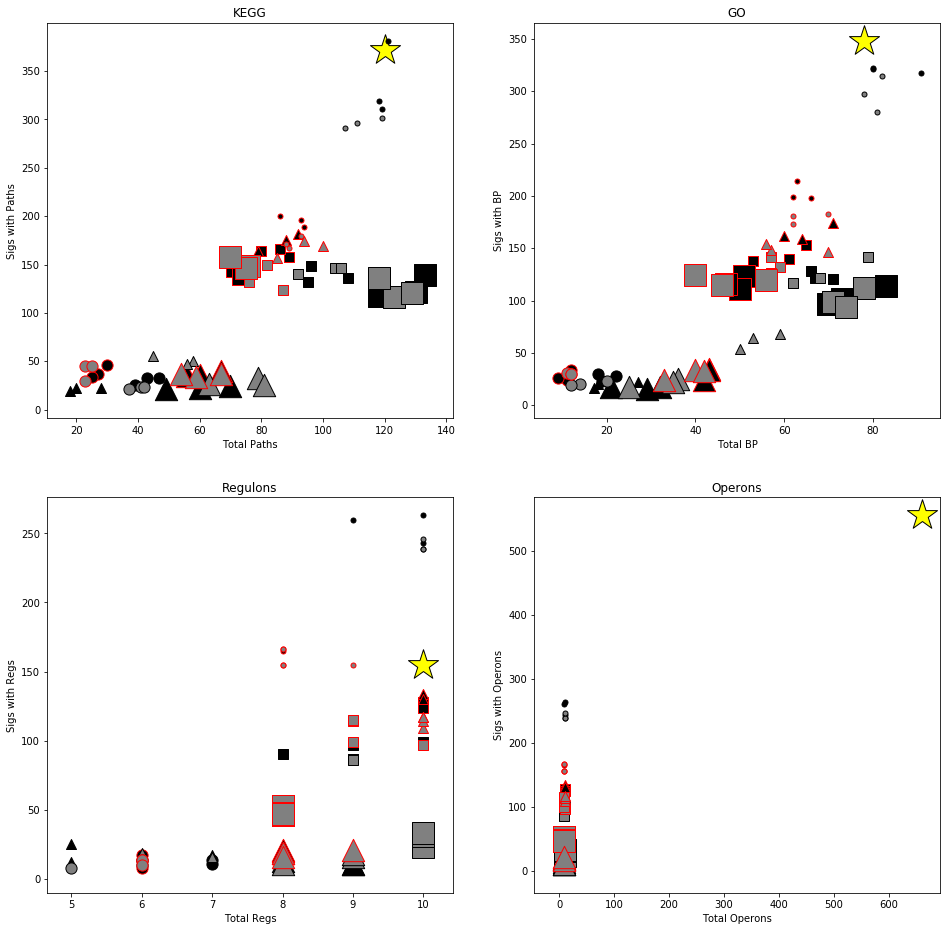

In [532]:
plimk=10
plimg=10
plimr=10
plimo=10
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(3):
                    seed = str(se+560)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict2[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                   # x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                   # y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)

                ec='red'
            mi = mi+1
        s=500
    c = 'grey'



In [526]:
fig.savefig('array_enrichments.png')

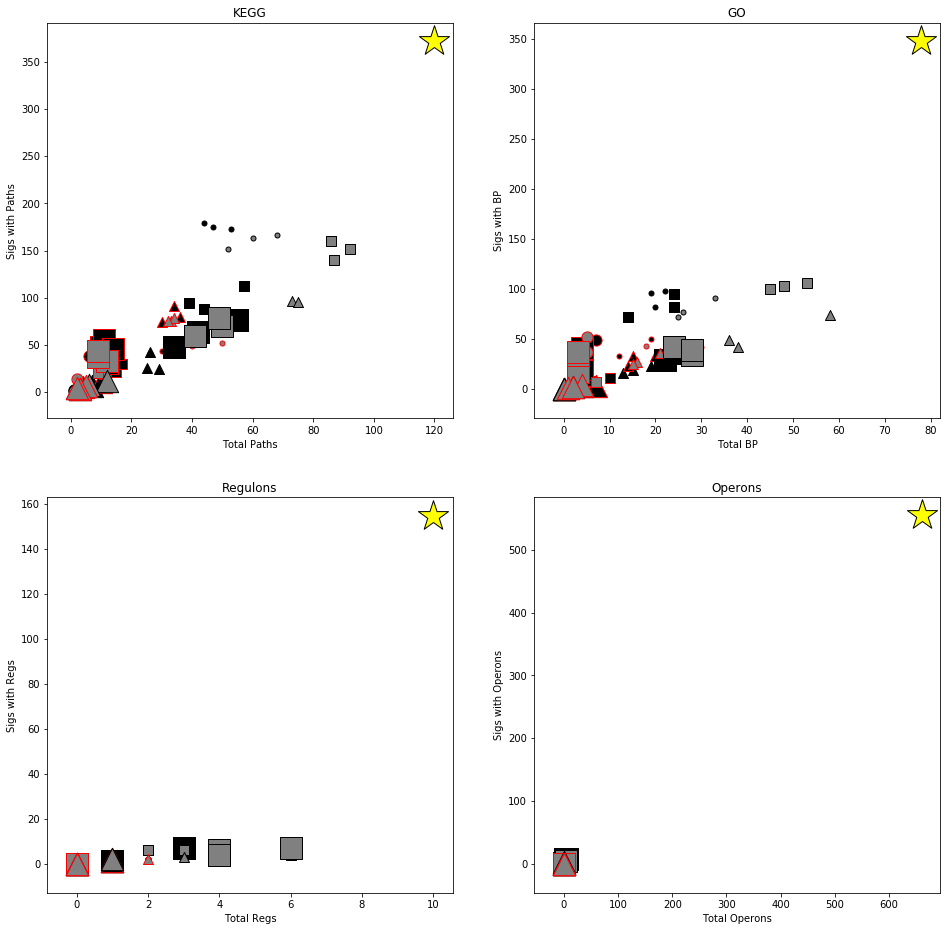

In [527]:
plimk=10
plimg=10
plimr=10
plimo=10
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(3):
                    seed = str(se+560)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict_seq2[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                   # x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                   # y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)

                ec='red'
            mi = mi+1
        s=500
    c = 'grey'



In [1]:
model_dict_seq3

NameError: name 'model_dict_seq3' is not defined

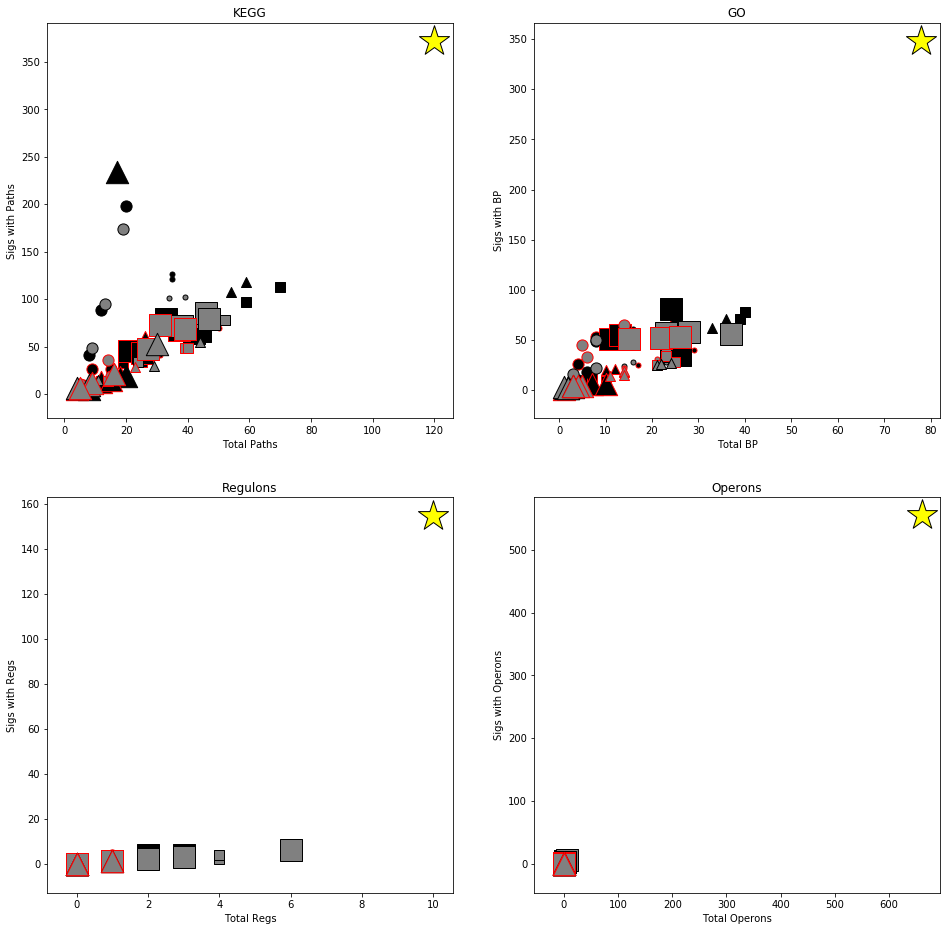

In [533]:
plimk=10
plimg=10
plimr=10
plimo=10
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(3):
                    seed = str(se+560)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict_seq3[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                   # x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                   # y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)

                ec='red'
            mi = mi+1
        s=500
    c = 'grey'



In [529]:
fig.savefig('seq_enrichments.png')

In [280]:
for m in model_dict_seq3:
    model_dict_seq3[m].set_hwg_cutoff(2.0)
    #model_dict_seq[m].set_op('node_interpretation/operons_format.txt')
    #print('op done')
    model_dict_seq3[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    #print('kegg done')
    model_dict_seq3[m].set_go('node_interpretation/manual_GO_BP_terms.txt') 
    #print('go done')
    model_dict_seq3[m].set_reg('node_interpretation/regulons_format.txt')
    #print('reg done')
    print(m)
print('dict seq done') 

plimk=10
plimg=10
plimr=10
plimo=10
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict_seq3['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict_seq3['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict_seq3['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict_seq3['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict_seq3['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict_seq3['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

#x = ((model_dict['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
#y = ((model_dict['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
#ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(3):
                    seed = str(se+560)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict_seq3[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                   # x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                   # y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)

                ec='red'
            mi = mi+1
        s=500
    c = 'grey'


False

## WRITE OUT GENE LISTS

In [443]:
model_dict3

{'tf_adage': <Adage.Adage at 0x7f6bffe070d0>,
 'ad_glorot_uniform_0_sigmoid_tiedTrue560': <Adage.Adage at 0x7f6b8487a310>,
 'ad_glorot_uniform_0_sigmoid_tiedTrue561': <Adage.Adage at 0x7f6c08843ed0>,
 'ad_glorot_uniform_0_sigmoid_tiedTrue562': <Adage.Adage at 0x7f6ba71e2150>,
 'ad_glorot_uniform_0_sigmoid_tiedFalse560': <Adage.Adage at 0x7f6c03ac6050>,
 'ad_glorot_uniform_0_sigmoid_tiedFalse561': <Adage.Adage at 0x7f6bfeb80850>,
 'ad_glorot_uniform_0_sigmoid_tiedFalse562': <Adage.Adage at 0x7f6b849ae650>,
 'ad_glorot_uniform_0_tanh_tiedTrue560': <Adage.Adage at 0x7f6b849ae6d0>,
 'ad_glorot_uniform_0_tanh_tiedTrue561': <Adage.Adage at 0x7f6b84861f50>,
 'ad_glorot_uniform_0_tanh_tiedTrue562': <Adage.Adage at 0x7f6b84813d10>,
 'ad_glorot_uniform_0_tanh_tiedFalse560': <Adage.Adage at 0x7f6b849c2890>,
 'ad_glorot_uniform_0_tanh_tiedFalse561': <Adage.Adage at 0x7f6bb8a7db90>,
 'ad_glorot_uniform_0_tanh_tiedFalse562': <Adage.Adage at 0x7f6b85252690>,
 'ad_glorot_uniform_0_relu_tiedTrue560': <

In [563]:
name = 'ad_glorot_normal_1e-05_tanh_tiedTrue560'
name = 'ad_glorot_uniform_0_tanh_tiedTrue560'
name = 'ad_glorot_uniform_0_sigmoid_tiedTrue560'
name = 'ad_glorot_normal_1e-05_tanh_tiedTrue560'
model_names = ['tf_adage','ad_glorot_normal_1e-05_tanh_tiedTrue560', 'ad_glorot_uniform_0_tanh_tiedTrue560',
              'ad_glorot_uniform_0_sigmoid_tiedTrue560']
hwgc = 0.0

for m in model_names:
    #model_temp = model_dict_seq3[name]
    model_temp = model_dict3[m]
    model_temp.set_hwg_cutoff(hwgc)
    hw_gene_lists = []
    weight_lists = []
    for n in range(model_temp.hw_genes_all.shape[1]):
        genes_temp = ['node'+str(n)]
        weights_temp = [1]
        for g in range(model_temp.hw_genes_all.shape[0]):
            if(model_temp.hw_genes_all[g,n]):
                #print(g)
                genes_temp.append(model_temp.compendium.index[g])
                weights_temp.append(abs(model_temp.weights[g,n % model_temp.weights.shape[1]]))

        genes_temp_sorted = [x for _,x in sorted(zip(weights_temp, genes_temp), reverse=True)]
        weights_temp_sorted = [x for _,x in sorted(zip(weights_temp, weights_temp), reverse=True)]
        hw_gene_lists.append(genes_temp_sorted)
        weight_lists.append(weights_temp_sorted)
        
    hw_gene_df = pd.DataFrame(hw_gene_lists).fillna('').values  
    hw_weight_df = pd.DataFrame(weight_lists).fillna(0).values  
    #hw_gene_lists[1]
    #write_data('test_hwgs.csv', hw_gene_lists)
    with open( 'new_models/' + m + "array_hwgs_" + str(hwgc) + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(hw_gene_df)
    with open(  'new_models/' + m + "array_hwg_weights_" + str(hwgc) + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(hw_weight_df)
        
    with open(  'new_models/' + m + "array_weights.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(model_temp.weights)
        
        
for m in model_names:
    #model_temp = model_dict_seq3[name]
    model_temp = model_dict_seq3[m]
    model_temp.set_hwg_cutoff(hwgc)
    hw_gene_lists = []
    weight_lists = []
    for n in range(model_temp.hw_genes_all.shape[1]):
        genes_temp = ['node'+str(n)]
        weights_temp = [1]
        for g in range(model_temp.hw_genes_all.shape[0]):
            if(model_temp.hw_genes_all[g,n]):
                #print(g)
                genes_temp.append(model_temp.compendium.index[g])
                weights_temp.append(abs(model_temp.weights[g,n % model_temp.weights.shape[1]]))

        genes_temp_sorted = [x for _,x in sorted(zip(weights_temp, genes_temp), reverse=True)]
        weights_temp_sorted = [x for _,x in sorted(zip(weights_temp, weights_temp), reverse=True)]
        hw_gene_lists.append(genes_temp_sorted)
        weight_lists.append(weights_temp_sorted)
        
    hw_gene_df = pd.DataFrame(hw_gene_lists).fillna('').values  
    hw_weight_df = pd.DataFrame(weight_lists).fillna(0).values 
    #hw_gene_lists[1]
    #write_data('test_hwgs.csv', hw_gene_lists)
    with open(  'new_models/' + m + "seq_hwgs_" + str(hwgc) + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(hw_gene_df)
    with open(  'new_models/' + m + "seq_hwg_weights_" + str(hwgc) + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(hw_weight_df)
        
    with open(  'new_models/' + m + "seq_weights.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(model_temp.weights)

## write out enrichments

In [497]:
model_temp.kegg_ps

[]

In [519]:
name = 'tf_adage'
#name = 'ad_glorot_uniform_0_tanh_tiedTrue560'
model_dict_seq3[name].set_reg('node_interpretation/regulons_format.txt') 

,Anr_regulon,PhoB_regulon,PvdR_regulon,PchR_regulon,AlgU_regulon,LasR_regulon,RhlR_regulon,PqsR_regulon,QscR_regulon,VreI_regulon
0,3.515272,0.777285,6.718862,3.111741,0.506846,0.680917,0.978198,0.916936,5.784154,2.227616
1,1.310983,0.682734,2.831144,2.981172,1.290197,1.678492,0.875319,0.816353,1.372065,2.101811
2,2.198471,1.462515,3.794460,3.947171,1.120229,1.344428,1.699294,1.628226,0.703815,3.043832
3,1.929693,3.098536,3.510287,3.662458,0.893108,13.889035,3.582050,8.913920,15.062785,2.763947
4,2.584913,4.466859,4.196414,4.349664,1.463733,7.329671,2.072309,1.998633,5.030659,3.441481
...,...,...,...,...,...,...,...,...,...,...
595,12.675450,3.648236,3.794460,3.947171,2.917954,1.344428,1.699294,6.890549,0.703815,3.043832
596,2.010416,3.262092,3.596129,3.748480,0.960088,5.341711,1.520056,1.450692,3.194471,2.848361
597,0.978063,0.427115,2.439636,2.587536,0.773726,1.096440,1.664003,1.545833,5.601526,1.727069
598,1.513812,2.276593,3.058929,3.209848,1.635339,8.129610,1.057647,0.994820,0.894500,2.322539


In [520]:

name = 'ad_glorot_normal_1e-05_tanh_tiedTrue560'
name = 'ad_glorot_uniform_0_tanh_tiedTrue560'
name = 'ad_glorot_uniform_0_sigmoid_tiedTrue560'
name = 'ad_glorot_normal_1e-05_tanh_tiedTrue560'
name = 'tf_adage'
model_temp = model_dict_seq3[name]
#model_temp = model_dict3[name]

node_paths_list=[]
for n in range(model_temp.hw_genes_all.shape[1]):
    paths_temp = ['node'+str(n)]
    for k in range(model_temp.regs_ps.shape[1]):
        if(model_temp.regs_ps.loc[n][k] > -np.log(0.01)):
            paths_temp.append(model_temp.regs_ps.columns[k])
    node_paths_list.append(paths_temp)
node_paths_list

with open("jie_adage_regs.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(node_paths_list)